<a href="https://colab.research.google.com/github/Nhyira-EM/Group40_FINALPROJECT_Image-Detection/blob/main/Group_40_FINAL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 40: Francine Arthur & Emmanuel Nhyira Freduah-Agyemang

## Installing necessary depedencies

In [1]:
!nvidia-smi

Fri Aug  2 16:55:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install -q supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 2.8 MB/s eta 0:00:00


In [4]:
!pip install yolov8
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 33.9/201.2 GB disk)


In [5]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os
import yaml
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Testing the original YOLO model on a random image

In [7]:
!yolo predict model=yolov8n.pt source='https://pluspng.com/img-png/3-600.png'

100% 6.25M/6.25M [00:00<00:00, 22.6MB/s]
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100% 190k/190k [00:00<00:00, 1.76MB/s]
image 1/1 /content/3-600.png: 352x640 4 bottles, 3 vases, 110.6ms
Speed: 4.1ms preprocess, 110.6ms inference, 730.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [8]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

results = model(source='https://pluspng.com/img-png/3-600.png',conf=0.25)


Found https://pluspng.com/img-png/3-600.png locally at 3-600.png
image 1/1 /content/3-600.png: 352x640 4 bottles, 3 vases, 77.8ms
Speed: 2.8ms preprocess, 77.8ms inference, 612.5ms postprocess per image at shape (1, 3, 352, 640)


In [9]:
print(results[0].boxes.xyxy)
print(results[0].boxes.conf)
print(results[0].boxes.cls)

tensor([[118.9315,  36.0616, 202.3550, 317.2841],
        [216.8284,  50.8475, 292.5716, 316.9789],
        [ 22.0731,  34.2123, 102.6914, 312.4978],
        [403.0132,  24.3651, 486.0969, 317.6219],
        [502.6528,   2.2121, 583.6051, 314.9268],
        [304.9555,  62.0947, 386.7677, 316.7363],
        [305.0865,  62.1426, 386.8435, 316.2259]], device='cuda:0')
tensor([0.9026, 0.8326, 0.8037, 0.7979, 0.7040, 0.4069, 0.2527], device='cuda:0')
tensor([39., 39., 39., 75., 75., 39., 75.], device='cuda:0')



0: 352x640 4 bottles, 3 vases, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


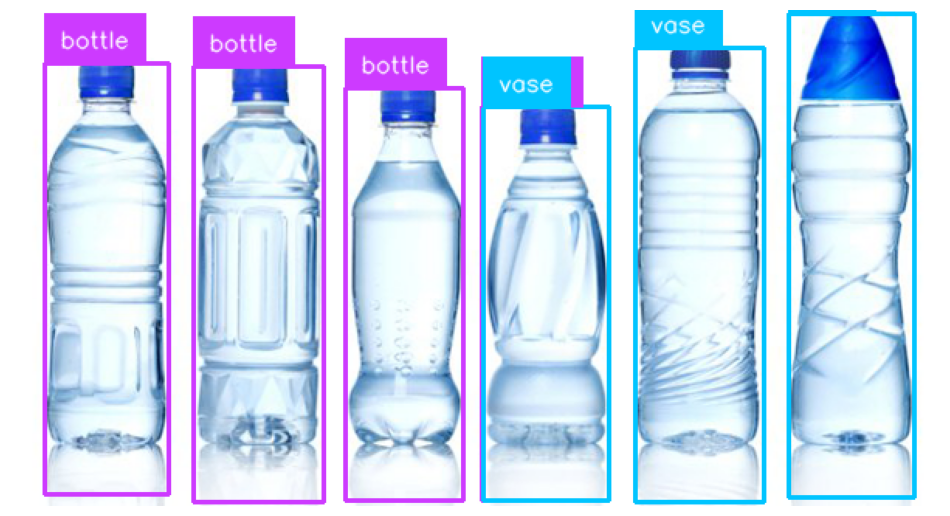

In [10]:
import cv2
import supervision as sv
from ultralytics import YOLO
import requests

model = YOLO('yolov8n.pt')
# Fetch image from URL and save it to a file
url = 'https://pluspng.com/img-png/3-600.png'
response = requests.get(url)

with open('image.png', 'wb') as f:
    f.write(response.content)

# Read the saved image file
image = cv2.imread('image.png')

results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_notations = sv.BoxAnnotator()
label_annotations = sv.LabelAnnotator()

annotated_image = bounding_box_notations.annotate(
    scene=image, detections=detections)
annotated_frame = label_annotations.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_frame)

## Generating weigths to balance the dataset.

In [11]:
# Path to our dataset annotations
annotations_path = '/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/train/labels'

# Function to extract labels from annotations
def extract_labels(annotations_path):
    labels = []
    for annotation_file in os.listdir(annotations_path):
        with open(os.path.join(annotations_path, annotation_file), 'r') as f:
            for line in f:
                # Split the line by spaces and take the first element as the class label
                class_label = int(line.split()[0])
                labels.append(class_label)
    return np.array(labels)

# Extract labels
y_train = extract_labels(annotations_path)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)


{0: 1.2077464788732395, 1: 0.8532338308457711}


In [12]:
# Editing the contents of our data.yaml file to account for the new weights for each class
data_yaml_path = '/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml'

# Read the data.yaml file
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Adding class weights to the data.yaml file
#data_yaml['class_weights'] = [class_weights_dict[i] for i in range(len(class_weights))]
data_yaml['class_weights'] = [float(w) for w in class_weights]

# Write the updated data.yaml back to the file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print("Updated data.yaml with class weights:", data_yaml['class_weights'])


Updated data.yaml with class weights: [1.2077464788732395, 0.8532338308457711]


## Modifying the model

In [13]:
import torch
import torch.nn as nn

In [14]:
# Loading the pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

#using the model
model.train(
    data='/content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/data.yaml',
    epochs = 100,
    patience = 5,
    batch=32,
    imgsz=640,
    device='cuda:0'
)

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

100%|██████████| 755k/755k [00:00<00:00, 4.32MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.77G     0.7219      2.474      1.271         89        640: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:30<00:00, 10.20s/it]

                   all        192        196      0.711     0.0166      0.283      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.36G     0.7476      1.657      1.277        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        192        196      0.475      0.129      0.359      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.37G     0.8024      1.466      1.304         86        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        192        196      0.378      0.594      0.434      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.37G     0.8069      1.405      1.296         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.436      0.516      0.494      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.37G     0.8242      1.329      1.289        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.694      0.355      0.314      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.37G     0.8407      1.238      1.302         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.458        0.6      0.417      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.37G     0.8282      1.185      1.296         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.543      0.731      0.645      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.37G     0.7959      1.122      1.283         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.616      0.693      0.697      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.37G     0.7924      1.012       1.29         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.714       0.67       0.75      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.37G     0.7873      1.006      1.259         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.682      0.808      0.773      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.37G     0.7368     0.9575      1.239         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.618      0.682      0.686      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.37G     0.7634     0.9247      1.259         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.444      0.375      0.303      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.37G     0.7494     0.9301      1.245         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.698      0.766      0.763      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.37G     0.7207      0.903      1.229         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.607      0.618      0.572      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.36G      0.728     0.8835       1.23         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.573      0.704      0.612      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.37G     0.7128     0.8493      1.218         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.772      0.828       0.85      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.37G     0.7021     0.8207      1.207         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.798      0.762      0.833      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.37G     0.6709     0.8024      1.192         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.683      0.666      0.718       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.37G     0.6485     0.7757       1.18         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.706      0.801      0.821      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.37G     0.6794     0.7851      1.203         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.74      0.718      0.793      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.37G     0.6468       0.77      1.182         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.835      0.777      0.879      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.37G     0.6597     0.7621      1.177         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.651      0.689      0.707      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.42G     0.6751     0.7877      1.203        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.845      0.875      0.879      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       4.4G     0.6674       0.76      1.192         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        192        196      0.837      0.877      0.934      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.36G     0.6313     0.7489      1.165         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.677      0.808      0.754       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.37G     0.6289     0.7511       1.17         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.879      0.808      0.918      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.37G     0.6371     0.7092      1.179         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196      0.893      0.844       0.93        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.37G     0.6044     0.6931      1.156         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all        192        196      0.805      0.791      0.843      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.37G     0.6315     0.7051      1.162         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.87      0.898      0.915      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.36G     0.6114     0.6992      1.148         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.862       0.92      0.953      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.36G     0.6166     0.6817      1.168         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196       0.83      0.801      0.899       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.36G     0.6097     0.6926      1.156         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.855      0.893      0.925      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.37G     0.6009     0.7036      1.146         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.835      0.864      0.904      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.36G     0.5963     0.6925      1.149        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.754      0.808      0.851      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.37G     0.5978     0.6815      1.142         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.824      0.892      0.918      0.806
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



35 epochs completed in 0.086 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


                   all        192        196      0.862       0.92      0.953      0.865
                 metal         83         83      0.813      0.964      0.952      0.896
               plastic        109        113      0.911      0.876      0.955      0.834
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9415cbe170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [15]:
metrics = model.val()  # evaluating model performance on the validation set

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


                   all        192        196      0.862       0.92      0.953      0.865
                 metal         83         83      0.813      0.964      0.952      0.896
               plastic        109        113      0.911      0.876      0.954      0.835
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train2


In [16]:
print(f"Validation mAP: {metrics.box.map}") #Model mean Average Presicion(mAP), basically like it's accurcy score

Validation mAP: 0.8653689425157275


## Checking the modified model's metrics

/content


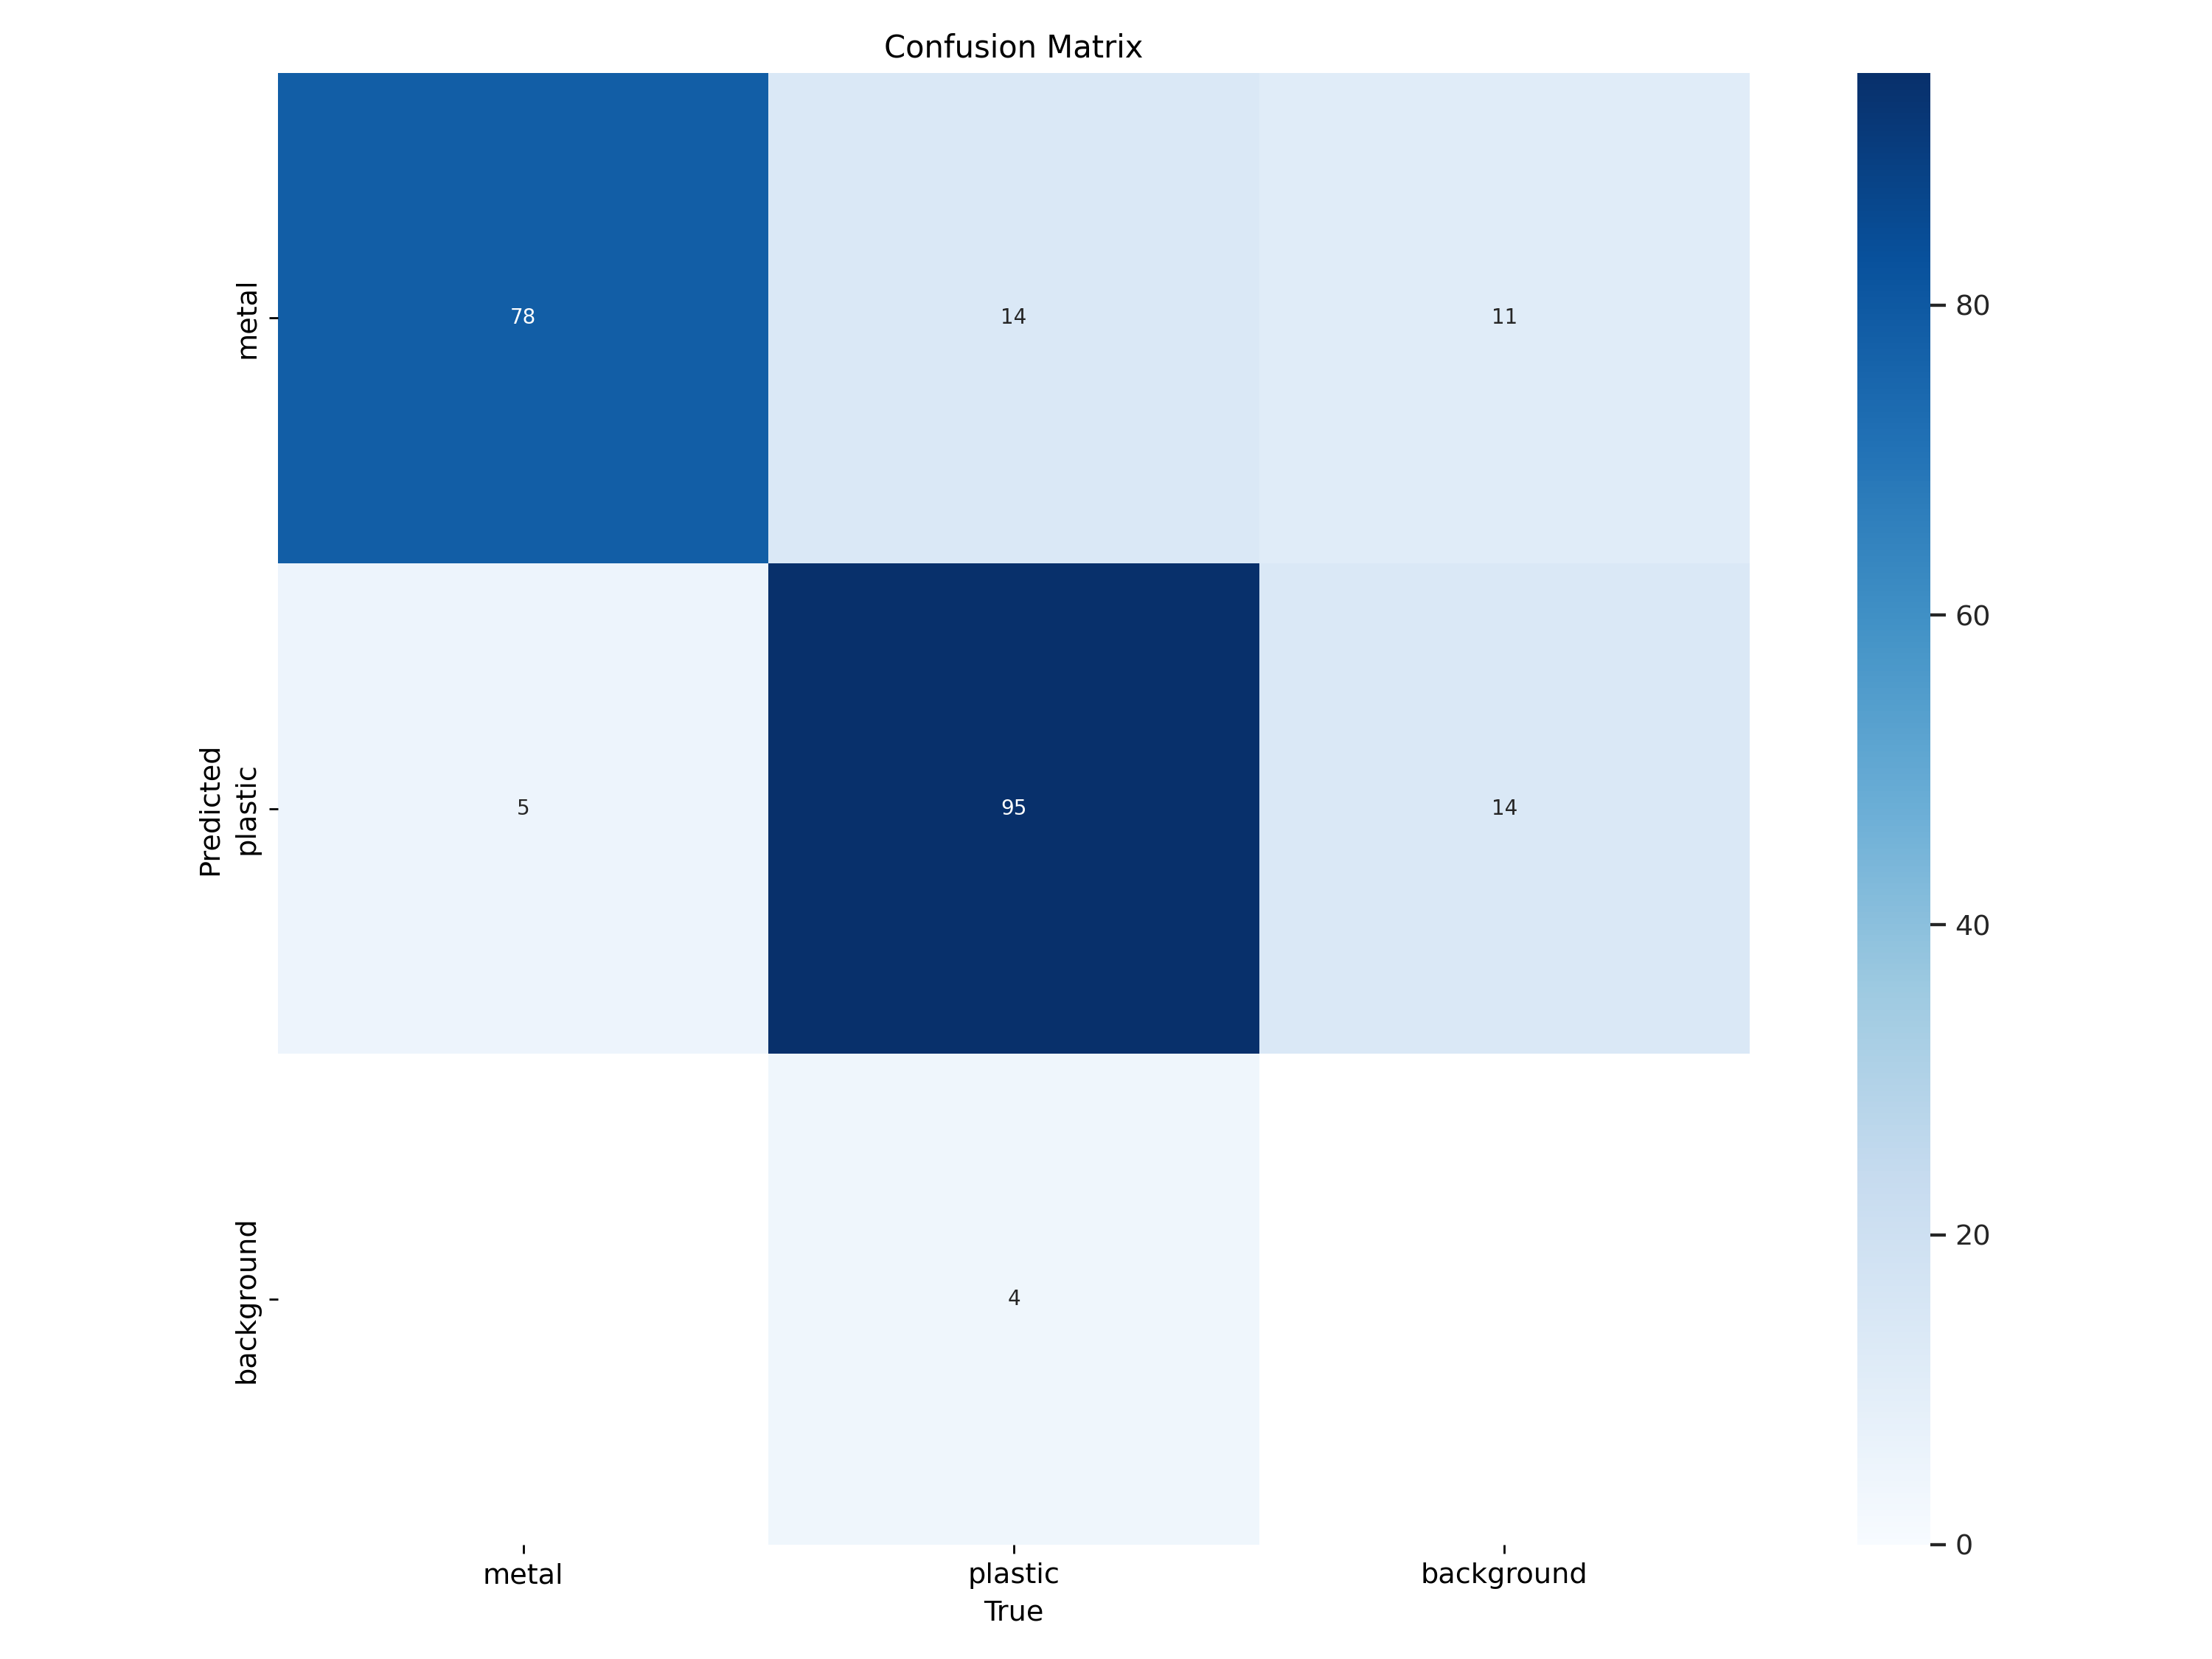

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)#confusion matrix

/content


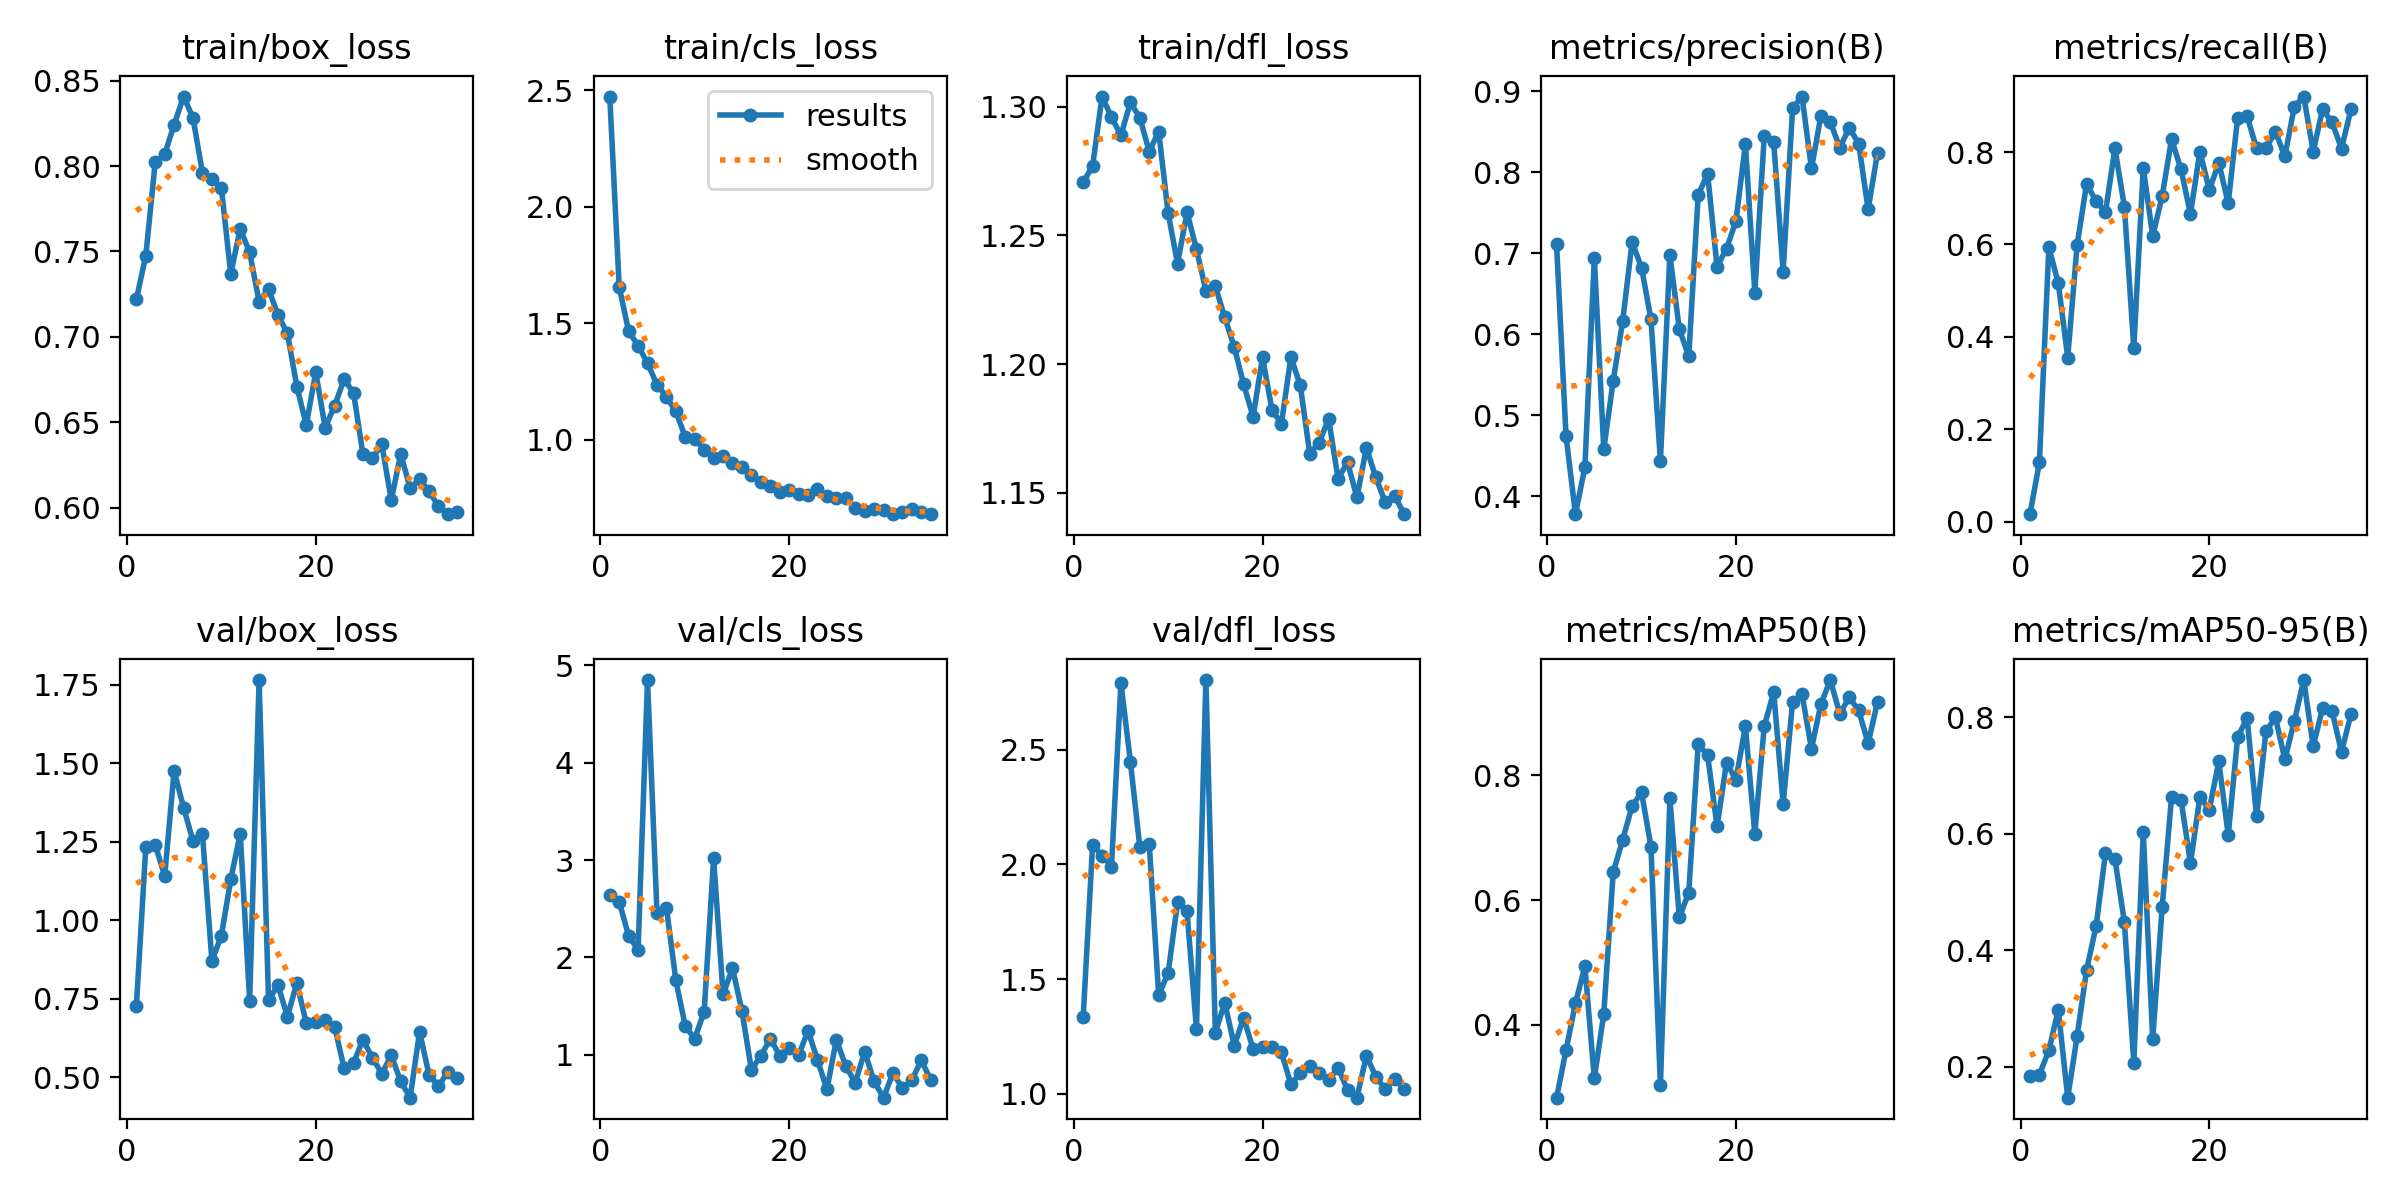

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)#results of the model

## Evaluating the modified model

In [19]:
model = YOLO('/content/runs/detect/train/weights/best.pt')
model.eval()

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.17G     0.5637     0.6676      1.128         45        640: 100%|██████████| 42/42 [00:08<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        192        196      0.917      0.916      0.964      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.28G      0.615     0.6835      1.157         38        640: 100%|██████████| 42/42 [00:06<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all        192        196       0.75      0.834      0.848      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.27G     0.6575     0.7409      1.178         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all        192        196      0.336      0.233      0.248     0.0776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.27G     0.6773     0.7784      1.207         42        640: 100%|██████████| 42/42 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        192        196      0.821       0.81      0.867      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.27G     0.6498     0.8008      1.179         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


                   all        192        196      0.707      0.769      0.784       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.27G     0.6721      0.766       1.19         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196        0.8      0.805      0.847       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.27G     0.6765     0.7381      1.199         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        192        196      0.829      0.892      0.933      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.27G     0.6925     0.7721       1.23         59        640: 100%|██████████| 42/42 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all        192        196      0.819      0.707      0.829      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.27G     0.6396     0.7226      1.178         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all        192        196      0.822      0.897      0.919      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.27G      0.636     0.6986      1.174         39        640: 100%|██████████| 42/42 [00:06<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all        192        196       0.84      0.828      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.27G       0.66     0.7454      1.193         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all        192        196      0.813      0.839      0.888       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.27G     0.6498     0.7496       1.19         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


                   all        192        196      0.788      0.911      0.892      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.27G      0.626     0.7156      1.171         58        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


                   all        192        196      0.863      0.896       0.93      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.27G      0.642      0.722      1.168         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]

                   all        192        196      0.909      0.901      0.953      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.27G     0.6337     0.6926      1.164         53        640: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


                   all        192        196      0.806      0.835      0.907      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.27G     0.6277     0.6608       1.15         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

                   all        192        196      0.839      0.904      0.923      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.28G     0.6144     0.6645      1.151         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all        192        196      0.857      0.796      0.889      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.27G     0.6058     0.6697      1.157         42        640: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]

                   all        192        196       0.73      0.798       0.76       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.27G     0.6036     0.6477      1.155         55        640: 100%|██████████| 42/42 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


                   all        192        196      0.376      0.397      0.311      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.27G     0.6135     0.6899       1.16         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        192        196      0.834      0.846      0.886      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.27G     0.6115     0.6564      1.156         36        640: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all        192        196      0.824      0.922      0.954      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.27G     0.6157     0.6945      1.162         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        192        196      0.911      0.936      0.968      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.27G     0.5918     0.6638      1.143         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


                   all        192        196      0.845      0.829       0.91      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.27G     0.6002     0.6257      1.157         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

                   all        192        196      0.864      0.921      0.939      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.27G     0.5911     0.6483      1.141         37        640: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196      0.841      0.897      0.932      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.27G     0.5851     0.6549      1.149         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


                   all        192        196       0.92      0.905      0.957      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.27G     0.5856     0.6441      1.155         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all        192        196      0.842      0.918      0.938      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.27G      0.574     0.6206       1.13         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        192        196      0.878      0.886      0.917      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.27G     0.5477     0.5744       1.12         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all        192        196      0.854      0.867      0.919      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.27G     0.5557     0.5843      1.111         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all        192        196      0.855      0.957       0.95      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.27G      0.564      0.598      1.132         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


                   all        192        196       0.86      0.789      0.898      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.27G     0.5518     0.6064      1.123         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all        192        196      0.822       0.89      0.909      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.27G     0.5737     0.6124      1.142         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

                   all        192        196       0.86      0.889      0.931      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.27G     0.5773     0.6185      1.135         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]

                   all        192        196      0.771      0.909      0.924      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.27G     0.5433     0.5923      1.109         48        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        192        196      0.893      0.938      0.963      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.31G     0.5692     0.6109      1.131         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

                   all        192        196      0.906      0.895      0.954      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.27G     0.5562     0.5913       1.13         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        192        196      0.846      0.819      0.907      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.27G      0.573     0.5919      1.149         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all        192        196      0.901      0.927      0.966      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.27G     0.5409     0.5426      1.114         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all        192        196      0.903      0.961      0.976      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.27G     0.5257     0.5518      1.107         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


                   all        192        196      0.897      0.921      0.961      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.27G     0.5774     0.5981      1.132         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all        192        196      0.888      0.903      0.946      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.27G     0.5517     0.5786      1.119         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


                   all        192        196      0.916      0.969      0.963      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.27G     0.5568     0.5681      1.109         42        640: 100%|██████████| 42/42 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


                   all        192        196      0.936      0.938       0.97      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.27G     0.5154     0.5553      1.104         53        640: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        192        196       0.92      0.925      0.958      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.27G     0.5336     0.5391      1.118         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


                   all        192        196      0.907      0.903      0.967      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.27G     0.5187     0.5346      1.103         48        640: 100%|██████████| 42/42 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all        192        196      0.904      0.931       0.96      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.27G      0.538     0.5374      1.117         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        192        196      0.905      0.919      0.964      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.27G     0.5533     0.5808      1.117         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]

                   all        192        196      0.897      0.933      0.971      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.29G     0.5108     0.5365      1.086         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


                   all        192        196      0.924      0.975      0.983      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.27G     0.5345       0.54      1.117         52        640: 100%|██████████| 42/42 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all        192        196      0.924      0.908      0.963      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.27G     0.5405     0.5324      1.111         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]

                   all        192        196      0.965      0.911       0.97      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.27G     0.5188     0.5472      1.103         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        192        196      0.956      0.954      0.979      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.27G     0.5206      0.512      1.095         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all        192        196      0.935      0.963      0.983      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.27G     0.4987     0.4861      1.086         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        192        196      0.829      0.941       0.96       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.28G     0.4917     0.5113      1.073         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        192        196      0.891      0.936      0.972      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.27G     0.5214     0.5199      1.103         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


                   all        192        196      0.935      0.934      0.962      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.27G     0.5078     0.5104      1.094         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        192        196      0.887      0.929      0.955      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.31G     0.4979     0.5148      1.078         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all        192        196      0.918      0.896      0.962      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.27G     0.5076     0.5341      1.094         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all        192        196      0.911      0.918      0.967      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.27G     0.5129     0.5313      1.092         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196      0.871      0.959      0.974      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.27G     0.4818     0.4773      1.077         40        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]

                   all        192        196      0.896      0.937      0.955      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.27G     0.5032     0.5008      1.087         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


                   all        192        196      0.955      0.942      0.975      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.27G     0.4888     0.4932      1.077         50        640: 100%|██████████| 42/42 [00:06<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]

                   all        192        196      0.906      0.925       0.97        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.27G     0.4987      0.493      1.097         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


                   all        192        196      0.933      0.912      0.969      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.27G     0.4912     0.4863      1.086         30        640: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        192        196      0.932      0.947      0.977      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.27G     0.4939     0.4915      1.092         35        640: 100%|██████████| 42/42 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        192        196      0.939      0.938      0.972      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.27G     0.4998      0.473      1.086         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all        192        196      0.877      0.925      0.964      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.27G     0.4945     0.4749      1.093         37        640: 100%|██████████| 42/42 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all        192        196      0.935       0.93      0.972      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.27G     0.4705     0.4568      1.072         50        640: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all        192        196      0.934      0.954       0.97      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.27G     0.4752     0.4735      1.076         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

                   all        192        196       0.93      0.939      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.27G     0.4836     0.4407       1.08         38        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

                   all        192        196      0.953      0.885      0.977      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.27G     0.4955     0.4762      1.087         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]

                   all        192        196      0.926      0.933      0.977      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.27G     0.4717     0.4591      1.072         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        192        196      0.932      0.943      0.976        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.27G     0.4598     0.4467      1.068         42        640: 100%|██████████| 42/42 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


                   all        192        196      0.924       0.92       0.97      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G     0.4809     0.4757      1.091         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


                   all        192        196      0.938      0.965       0.98      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.27G     0.4691     0.4578      1.067         47        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        192        196      0.935       0.94      0.965      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.27G     0.4675     0.4603      1.069         49        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all        192        196      0.946      0.939      0.974      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.27G     0.4583     0.4428       1.06         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

                   all        192        196      0.946       0.95      0.985      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.27G     0.4703     0.4577      1.069         48        640: 100%|██████████| 42/42 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


                   all        192        196      0.962      0.956      0.979      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.27G     0.4617      0.429      1.067         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all        192        196      0.878      0.955      0.963      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.27G     0.4671     0.4326      1.064         34        640: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196      0.951      0.945      0.976      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.27G      0.456     0.4223      1.063         43        640: 100%|██████████| 42/42 [00:06<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.99it/s]

                   all        192        196      0.963      0.941      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.27G      0.459     0.4337      1.065         41        640: 100%|██████████| 42/42 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all        192        196      0.953      0.935      0.983      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.27G      0.462     0.4363      1.067         46        640: 100%|██████████| 42/42 [00:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all        192        196      0.927      0.958      0.977      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.27G     0.4504     0.4263      1.051         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        192        196      0.924      0.957      0.982      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.27G     0.4475     0.4428      1.063         39        640: 100%|██████████| 42/42 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


                   all        192        196      0.943      0.949      0.979      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.27G     0.4613     0.4361      1.066         45        640: 100%|██████████| 42/42 [00:06<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196      0.943       0.95      0.985      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.27G     0.4315     0.4152      1.054         51        640: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

                   all        192        196      0.931      0.974      0.981      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.27G     0.4464     0.4328      1.064         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all        192        196      0.926      0.963       0.98      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.27G     0.4467     0.4227      1.056         44        640: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

                   all        192        196      0.926       0.96      0.976      0.921


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.27G     0.2245     0.2962     0.9115         14        640: 100%|██████████| 42/42 [00:08<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        192        196      0.922      0.966      0.977      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.27G     0.2117     0.2488     0.8888         20        640: 100%|██████████| 42/42 [00:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all        192        196      0.921      0.964      0.985      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.27G     0.2062     0.2451     0.8752         13        640: 100%|██████████| 42/42 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]

                   all        192        196       0.94      0.951      0.979       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.27G     0.2012     0.2305     0.8842         13        640: 100%|██████████| 42/42 [00:06<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all        192        196      0.942      0.945      0.979      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.27G      0.197     0.2232     0.8677         15        640: 100%|██████████| 42/42 [00:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        192        196      0.945      0.966      0.984       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.27G     0.1921     0.2206     0.8735         15        640: 100%|██████████| 42/42 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

                   all        192        196      0.944      0.966      0.983      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.27G     0.1915     0.2329       0.88         16        640: 100%|██████████| 42/42 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all        192        196       0.94       0.97      0.985      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.27G     0.1975     0.2186     0.8957         12        640: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]

                   all        192        196      0.935      0.962      0.985      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.27G     0.1936     0.2049     0.8745         13        640: 100%|██████████| 42/42 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]

                   all        192        196      0.937      0.962      0.984      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.27G     0.1875     0.2215     0.8556         11        640: 100%|██████████| 42/42 [00:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


                   all        192        196      0.938      0.971      0.984      0.947

100 epochs completed in 0.238 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


                   all        192        196      0.936      0.971      0.984      0.946
                 metal         83         83      0.971      0.976      0.989      0.968
               plastic        109        113      0.901      0.967      0.979      0.925
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c921830fa00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Testing the modified model on some images it has never seen before

In [20]:
results = model.predict(source ='https://media.healthyfood.com/wp-content/uploads/2017/03/Ask-the-experts-Plastic-water-bottles-600x402.jpg', save=True)
for result in results:
    print(result.boxes.data)

100%|██████████| 12.9k/12.9k [00:00<00:00, 16.3MB/s]

image 1/1 /content/Ask-the-experts-Plastic-water-bottles-600x402.jpg: 448x640 2 plastics, 76.5ms
Speed: 1.9ms preprocess, 76.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/train32
tensor([[ 72.9378,  21.2169, 464.2964, 348.5833,   0.8422,   1.0000],
        [320.9252,  21.0549, 462.9710, 349.3673,   0.5574,   1.0000]], device='cuda:0')


In [21]:
results = model.predict(source ='https://i.ytimg.com/vi/nnOeZTqqp60/maxresdefault.jpg', save=True)
for result in results:
    print(result.boxes.data)

100%|██████████| 86.3k/86.3k [00:00<00:00, 58.3MB/s]

image 1/1 /content/maxresdefault.jpg: 384x640 3 metals, 70.6ms
Speed: 1.7ms preprocess, 70.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train33
tensor([[1.3922e+02, 3.2500e+01, 6.9109e+02, 7.1617e+02, 7.5770e-01, 0.0000e+00],
        [1.3272e+02, 3.8527e+01, 1.0060e+03, 7.1633e+02, 7.0040e-01, 0.0000e+00],
        [5.5526e+02, 3.4760e+01, 1.1404e+03, 5.7450e+02, 2.8784e-01, 0.0000e+00]], device='cuda:0')


## Hyper parameter tuning of the modified model

In [23]:
import torch
from ultralytics import YOLO
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters to tune
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'optimizer':['Adam','SGD'],
    'patience':[5,10,15]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Load the YOLOv8 model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Function to train and evaluate the model
def train_and_evaluate(params):

    # Train the model
    model.train(data='/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml', epochs=100,lr0=params['lr'],batch=32,patience=params['patience'],optimizer=params['optimizer'] )

    # Evaluate the model
    results = model.val()

    # Return the performance metric (e.g., mAP)
    return results.box.map

# Iterate over all combinations of hyperparameters
best_params = None
best_score = -float('inf')

for params in grid:
    print(f"Evaluating with parameters: {params}")
    score = train_and_evaluate(params)
    print(f"Score: {score}")

    if score > best_score:
        best_score = score
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Evaluating with parameters: {'lr': 0.001, 'optimizer': 'Adam', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None,

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.85G     0.6058     0.6984      1.153         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.802      0.496      0.569      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G     0.5733      0.621       1.14        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.809        0.8      0.804       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.42G      0.579     0.6306      1.157         86        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196       0.92      0.902      0.962      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.42G     0.5946     0.6719      1.155         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.776      0.825      0.853      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.42G     0.5826     0.6787      1.135        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.828      0.817      0.889      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.42G     0.5812     0.6307      1.143         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.873      0.823      0.902      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.42G     0.5801     0.6409       1.13         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.861      0.805      0.914      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.45G     0.5927     0.6583       1.14         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.767      0.841       0.91       0.81
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 0.030 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


                   all        192        196       0.92      0.901      0.962      0.863
                 metal         83         83      0.917      0.936      0.964      0.909
               plastic        109        113      0.923      0.867      0.959      0.817
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/train4
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


                   all        192        196      0.921      0.902      0.961      0.863
                 metal         83         83      0.917      0.937      0.964      0.909
               plastic        109        113      0.924      0.867      0.959      0.816
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train42
Score: 0.8625927008765399
Evaluating with parameters: {'lr': 0.001, 'optimizer': 'Adam', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=Fals

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G      1.432      1.347      1.762         89        640: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G      0.723     0.7571      1.264        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all        192        196      0.636     0.0193      0.323      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.42G     0.6694     0.6734       1.22         86        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.356      0.904      0.603      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.42G     0.6619     0.7001      1.214         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.774      0.698      0.743      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.42G     0.6444     0.7127      1.191        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.824      0.824      0.906      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.42G      0.621     0.6581      1.182         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.842      0.829      0.919      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.42G     0.6096     0.6341      1.162         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.887      0.925      0.954      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.45G      0.598     0.6522      1.166         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.841      0.929      0.951      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.42G     0.6061     0.6135      1.167         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.937      0.921      0.971      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.42G      0.605     0.6245       1.16         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.929      0.881      0.961      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.42G     0.5614     0.6017      1.141         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.949      0.914      0.965      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.42G      0.583     0.5932      1.143         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.906       0.93      0.968      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.42G     0.5687      0.596       1.14         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.892      0.924      0.949      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.42G     0.5449     0.5647      1.128         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.905      0.907      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.45G      0.558     0.5888      1.138         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.929      0.906      0.969      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.42G     0.5655     0.5817      1.136         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.927      0.935      0.969      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.42G     0.5507     0.5532       1.12         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.915      0.912      0.947      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.42G     0.5583     0.5662      1.123         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.861      0.838      0.929      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.42G     0.5309     0.5424      1.114         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.947      0.921      0.966      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.42G     0.5492     0.5577      1.123         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.913       0.95      0.973      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.45G     0.5239     0.5483       1.11         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.941      0.945      0.975      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.42G     0.5322      0.554      1.114         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.881      0.953      0.972      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.48G     0.5593     0.5499      1.133        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.879       0.94      0.956      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.46G     0.5458     0.5568      1.118         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.853      0.961       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.42G     0.5262     0.5396      1.101         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.904      0.962      0.969      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.42G      0.519     0.5607      1.104         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196       0.89      0.941      0.967      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.42G     0.5075     0.5331      1.099         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.933      0.951      0.976      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.42G     0.5162     0.5237      1.101         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196       0.94      0.939      0.968      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.42G     0.5221     0.5347      1.105         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.926      0.942       0.97      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.42G     0.5172     0.5487      1.097         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.893      0.932      0.938      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.42G     0.5464     0.5545      1.129         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.932      0.964      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.42G     0.5395     0.5259      1.124         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.933      0.942      0.984      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.42G     0.5079     0.5579        1.1         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.915      0.965      0.984      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.45G     0.5267     0.5532      1.112        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.946      0.925       0.97      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.42G     0.5214     0.5286      1.107         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.922       0.96      0.974      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.42G     0.5258      0.512      1.108         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196       0.88      0.952      0.957       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.42G     0.5069     0.5052      1.107         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.927       0.88      0.938      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.42G     0.5226     0.5397      1.114         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.902       0.91      0.953      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.42G     0.4934     0.4823      1.099         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.913       0.92      0.968        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.45G     0.5152     0.5017        1.1         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.91      0.966      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.42G     0.5242     0.5382      1.113         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.939      0.951      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.42G     0.4871     0.4857      1.085        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.856      0.866      0.949      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.45G     0.4961     0.4872      1.095         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.952      0.951      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.42G     0.4851      0.476      1.094         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.951      0.954      0.982      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.42G     0.4913     0.5024      1.101         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.875      0.909      0.958      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.42G      0.489     0.4959      1.087         74        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.896      0.875      0.954      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.42G      0.514      0.494      1.104         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.951      0.889      0.966      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.45G     0.4906     0.4739      1.084         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        192        196      0.932      0.976      0.966      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.42G     0.5003     0.4726      1.094         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.917      0.955      0.974      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.42G     0.4898     0.4932      1.081         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.928      0.949      0.963      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.42G     0.4984     0.4752      1.097         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.927      0.954      0.976      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.45G     0.5041     0.4866      1.093         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.948      0.926      0.972      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.42G     0.4941     0.4747      1.091         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196       0.92      0.939      0.952      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.42G     0.4752     0.4704      1.091         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.927      0.939      0.967      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.42G     0.4518      0.447      1.059         80        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.901       0.96      0.966      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.42G     0.4928     0.4843      1.089         83        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.923      0.949      0.971      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.45G     0.4695     0.4408      1.074         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.918      0.953      0.973      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.42G     0.4879     0.4728      1.073         78        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.928      0.953      0.968      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.42G     0.4543     0.4611      1.064         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.939       0.95      0.966      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.42G      0.479     0.4538      1.083         83        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.949      0.943      0.981      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.42G     0.4633     0.4434      1.069         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.939       0.94      0.979      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.42G     0.4861     0.4553      1.085         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.931       0.96      0.984      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.42G     0.4716      0.468      1.076         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.937       0.96      0.972      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.45G     0.4821      0.478      1.084        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.916      0.961       0.97      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.42G     0.4542     0.4461      1.072         81        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.925      0.949       0.97      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.42G      0.478     0.4738      1.082         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.942      0.966      0.963      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.46G     0.4539      0.438      1.067         78        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.908      0.968      0.972      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.42G     0.4625     0.4456       1.08         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.934      0.934      0.973      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.42G     0.4519     0.4187       1.07         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.893      0.966      0.965      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.42G     0.4557     0.4433      1.076        105        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.928      0.956      0.966      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.42G     0.4579     0.4357      1.068         95        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.933      0.954      0.981      0.914
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 61, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



71 epochs completed in 0.176 hours.
Optimizer stripped from runs/detect/train43/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train43/weights/best.pt, 6.3MB

Validating runs/detect/train43/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


                   all        192        196      0.939       0.94      0.979      0.922
                 metal         83         83      0.975      0.933      0.987      0.947
               plastic        109        113      0.903      0.947      0.971      0.898
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train43
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


                   all        192        196      0.939       0.94      0.979       0.92
                 metal         83         83      0.975      0.932      0.987      0.945
               plastic        109        113      0.903      0.947       0.97      0.896
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train432
Score: 0.9202228762131988
Evaluating with parameters: {'lr': 0.001, 'optimizer': 'Adam', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=Fa

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G      1.012      1.066      1.421         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G      0.523     0.5228      1.105        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196       0.34      0.662      0.485       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G      0.533     0.5033      1.128         86        640: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.751      0.879      0.899       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G     0.5389     0.5351      1.117         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.885       0.89       0.95      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G     0.5135     0.5475      1.095        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.912      0.924       0.97      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G     0.5244     0.5195      1.107         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.898      0.912      0.948      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G     0.5188     0.5079      1.095         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.917      0.942      0.956      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.44G     0.5218     0.5227      1.104         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.898      0.941      0.967      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.44G     0.5159     0.4962      1.104         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.921      0.945      0.977      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G     0.5335     0.5059      1.102         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.923      0.949      0.976      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.44G      0.506     0.4984      1.102         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.903      0.927      0.975      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.44G     0.5297      0.511      1.106         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196        0.9      0.924      0.962      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G      0.515     0.5003      1.103         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        192        196      0.907      0.941      0.971      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G     0.4974     0.4806      1.084         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.911       0.96      0.975      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.44G     0.5049     0.4946      1.095         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.932      0.961      0.983      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.44G     0.5169     0.5149      1.103         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.867      0.914      0.951      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.44G     0.4946     0.4794      1.081         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.949       0.95      0.974      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.4967     0.4826       1.08         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.912      0.956      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G     0.4824     0.4646      1.081         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.933      0.949      0.966      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.44G     0.5018     0.4818       1.09         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196       0.94      0.939      0.971      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.44G     0.4728     0.4683      1.072         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.931      0.932      0.966      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.44G     0.4961     0.4777      1.081         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.899      0.938      0.963      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       4.5G     0.5038     0.4685      1.102        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.916      0.936      0.962      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.48G     0.4932     0.4727      1.084         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.918      0.947      0.972      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.44G     0.4778     0.4606      1.068         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.938      0.942      0.966      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G     0.4815     0.4838      1.079         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196       0.87      0.943      0.946      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G     0.4919     0.4805      1.082         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.923      0.954      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.44G     0.4782     0.4658      1.072         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.911      0.949      0.951      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.44G      0.487     0.4815       1.08         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.972      0.937      0.972      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.44G     0.4664     0.4751      1.065         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.932      0.932       0.96      0.895
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



30 epochs completed in 0.100 hours.
Optimizer stripped from runs/detect/train433/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train433/weights/best.pt, 6.2MB

Validating runs/detect/train433/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


                   all        192        196      0.932      0.961      0.983      0.906
                 metal         83         83      0.963      0.949      0.984      0.933
               plastic        109        113      0.901      0.973      0.981      0.879
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/train433
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


                   all        192        196      0.932      0.962      0.983      0.908
                 metal         83         83      0.963       0.95      0.984      0.935
               plastic        109        113      0.901      0.973      0.981       0.88
Speed: 0.2ms preprocess, 6.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train4332
Score: 0.9077519909018223
Evaluating with parameters: {'lr': 0.001, 'optimizer': 'SGD', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=Fals

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4333/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G      1.568      1.597      1.758         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.495      0.373      0.325      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.42G     0.8214     0.8621      1.332        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.909      0.788      0.887      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.42G      0.618     0.6611       1.23         86        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.889      0.928      0.945       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.42G     0.5773     0.6116      1.187         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.903       0.95      0.957      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.42G     0.5249     0.5611      1.134        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.913      0.944      0.958      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.42G     0.5072     0.5276      1.117         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.917       0.94      0.962      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.42G     0.4957     0.5041      1.098         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.926      0.941      0.966      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.42G     0.4831     0.4894      1.094         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.937      0.955      0.966      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.42G     0.4595     0.4551      1.083         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.935      0.954      0.964      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.42G     0.4736     0.4663      1.076         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.926      0.951      0.964      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.42G     0.4467     0.4568      1.074         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.936      0.951      0.973      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.42G     0.4605     0.4631      1.073         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196       0.89      0.967      0.968      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.42G     0.4566     0.4604      1.068         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.897      0.953      0.968      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.42G     0.4396     0.4256      1.058         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.925      0.968      0.972      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.42G     0.4716     0.4681      1.085         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.926      0.976      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.42G     0.4836     0.4696      1.088         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.921      0.957      0.971      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.42G     0.4687     0.4557       1.07         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.917      0.974      0.968      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.42G     0.4714     0.4712      1.077         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.935      0.966      0.967      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.42G     0.4576     0.4569      1.072         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.953      0.954      0.973      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.42G     0.4694     0.4536      1.083         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.936       0.96      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.42G     0.4498     0.4613      1.064         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.921      0.946      0.969      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.42G     0.4622      0.451      1.072         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.915      0.941      0.965      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.48G     0.4809     0.4568      1.088        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.923      0.951      0.966      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.45G     0.4718     0.4662      1.075         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.935      0.955      0.972      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.42G      0.447     0.4486      1.061         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.945      0.967      0.978      0.919
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



25 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train4333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4333/weights/best.pt, 6.2MB

Validating runs/detect/train4333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


                   all        192        196      0.936       0.96      0.974      0.921
                 metal         83         83      0.964      0.965      0.978      0.947
               plastic        109        113      0.907      0.955      0.969      0.895
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train4333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


                   all        192        196      0.936       0.96      0.974       0.92
                 metal         83         83      0.964      0.965      0.978      0.947
               plastic        109        113      0.907      0.955      0.969      0.894
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train43332
Score: 0.9202563634993673
Evaluating with parameters: {'lr': 0.001, 'optimizer': 'SGD', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43333/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G     0.7229     0.7556      1.232         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.703      0.588      0.622      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G     0.4755     0.4716      1.088        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.897      0.904      0.933      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G      0.474     0.4538      1.104         86        640: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.938      0.931       0.96      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G     0.4626     0.4625      1.089         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196       0.93      0.961      0.965        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G     0.4455      0.447      1.064        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.935      0.963      0.968      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G     0.4403     0.4278      1.067         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.913       0.96      0.972      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G     0.4367     0.4308      1.056         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.922      0.964      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G     0.4359     0.4289       1.06         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.914      0.968      0.968      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G     0.4238     0.4079      1.057         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.909      0.966      0.968      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G     0.4353     0.4156      1.052         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.922      0.959       0.97      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G     0.4142     0.4118      1.054         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.948      0.949      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G     0.4297     0.4168      1.053         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.916      0.954      0.973      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G     0.4285      0.422       1.05         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.881      0.973       0.97       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G     0.4217     0.3965      1.045         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196       0.91      0.972      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.46G     0.4421     0.4315      1.068         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.921      0.976      0.974      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G     0.4569     0.4316      1.071         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.913       0.97      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G     0.4482     0.4255      1.057         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.928       0.96      0.975       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.43G     0.4495     0.4356      1.063         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196      0.941      0.962       0.97      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.43G      0.441      0.428      1.062         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.942      0.975      0.973      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.43G     0.4593     0.4298      1.075         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.916      0.973      0.973       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.46G     0.4452     0.4418      1.059         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.934      0.958      0.974       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.43G     0.4563     0.4327      1.068         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.926      0.953      0.968      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.49G     0.4712     0.4419      1.081        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        192        196      0.933      0.951      0.967      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.47G     0.4651     0.4561       1.07         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196       0.94      0.969      0.976      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.43G     0.4402     0.4325      1.055         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.953      0.971      0.979      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.43G     0.4546     0.4543      1.067         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.934      0.962      0.976      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.43G     0.4475     0.4288      1.064         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.949      0.966      0.981      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.43G     0.4503     0.4308      1.062         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.931      0.973       0.98      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.43G     0.4544     0.4325      1.064         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.942      0.967      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.43G     0.4407     0.4379      1.055         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.941       0.97      0.982      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.43G     0.4609      0.443      1.076         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.931      0.973      0.972       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.43G     0.4612     0.4366      1.078         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.926      0.974       0.97       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.43G     0.4344     0.4467      1.056         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196        0.9      0.963      0.966      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.46G     0.4661     0.4575      1.077        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.935      0.957      0.972      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.43G     0.4457     0.4366      1.061         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.946      0.954      0.979      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.43G     0.4631     0.4301      1.075         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.953       0.96      0.981      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.43G     0.4466     0.4171      1.069         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196       0.95      0.978      0.983      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.43G       0.45     0.4328      1.071         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.948      0.956       0.98      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.43G     0.4328     0.4025       1.06         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.941      0.955      0.979      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.46G     0.4517     0.4225      1.061         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196      0.922      0.963      0.977       0.92
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.120 hours.
Optimizer stripped from runs/detect/train43333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train43333/weights/best.pt, 6.2MB

Validating runs/detect/train43333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


                   all        192        196      0.943       0.97      0.982      0.925
                 metal         83         83      0.976      0.975      0.988      0.954
               plastic        109        113       0.91      0.965      0.976      0.896
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/train43333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


                   all        192        196      0.941       0.97      0.982      0.927
                 metal         83         83      0.976      0.976      0.988      0.954
               plastic        109        113      0.907      0.965      0.976      0.901
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/train433332
Score: 0.9272964168390055
Evaluating with parameters: {'lr': 0.001, 'optimizer': 'SGD', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cl

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433333/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.23G     0.6053     0.6294      1.164         89        640: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.791      0.672       0.75      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.42G     0.4355     0.4217       1.06        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.897      0.883      0.929      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.42G     0.4421     0.4182      1.078         86        640: 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all        192        196       0.94      0.941      0.969      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.42G     0.4327     0.4257      1.065         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.941      0.964      0.974      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.42G     0.4192     0.4109      1.044        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.954      0.953       0.98      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.42G     0.4154     0.3974      1.047         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.938      0.955      0.981      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.42G     0.4074     0.3958      1.038         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.928      0.968       0.98      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.45G     0.4092     0.3942      1.043         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.925      0.965      0.976      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.42G     0.4064      0.383      1.043         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.926      0.953      0.975       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.42G     0.4119     0.3865      1.036         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.931      0.965      0.975      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.42G     0.3987     0.3864      1.041         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.934      0.971      0.979       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.42G     0.4142     0.3914      1.041         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.932      0.943      0.977      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.42G     0.4108     0.3945      1.037         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.901      0.966       0.97      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.42G     0.4039     0.3756      1.035         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.919      0.977      0.974       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.45G     0.4222     0.4067      1.055         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.932      0.961      0.971      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.42G     0.4329     0.4077      1.056         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.918      0.972      0.973      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.42G     0.4284     0.4007      1.043         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.953      0.949      0.973      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.42G     0.4277     0.4054      1.048         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.94      0.963      0.966      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.42G     0.4192     0.3945      1.049         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.938      0.959      0.968      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.42G     0.4364     0.4009      1.059         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.943      0.966      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.45G     0.4221     0.4093      1.044         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.943      0.946      0.975      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.42G     0.4359     0.4078      1.057         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.945      0.949       0.97      0.914
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.082 hours.
Optimizer stripped from runs/detect/train433333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train433333/weights/best.pt, 6.2MB

Validating runs/detect/train433333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


                   all        192        196      0.928      0.968       0.98      0.928
                 metal         83         83      0.976      0.972      0.989      0.955
               plastic        109        113       0.88      0.965       0.97      0.901
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/train433333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


                   all        192        196      0.928      0.967       0.98      0.928
                 metal         83         83      0.976       0.97      0.989      0.955
               plastic        109        113       0.88      0.965       0.97      0.901
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train4333332
Score: 0.9280115175379601
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'Adam', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_c

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4333333/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.23G     0.6951     0.7431      1.214         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.545      0.526      0.457       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.42G     0.8146     0.8908      1.282        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196       0.45      0.425      0.343      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G      0.883     0.9376      1.326         86        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.574      0.591      0.554      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G     0.8668      0.965      1.319         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196       0.61      0.414      0.259      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G     0.8913      1.041      1.327        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196       0.18     0.0767     0.0339     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G     0.8864     0.9782      1.324         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.197      0.519       0.15     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G     0.8952          1      1.319         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.458      0.729      0.595      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G     0.8561     0.9813      1.308         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.573      0.683      0.646      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G     0.8804     0.9184      1.318         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.623      0.641      0.647      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G     0.8805     0.9541      1.297         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.782      0.752      0.772      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G     0.8304     0.9134      1.297         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.779      0.758      0.833      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G     0.8388     0.8957      1.302         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.707      0.742      0.764      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G     0.7962     0.8563      1.264         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.773      0.805      0.843      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G     0.7882     0.8611      1.262         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196      0.761      0.864      0.908       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.46G     0.8066      0.864      1.266         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.737      0.739      0.804      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G     0.8029     0.8745      1.257         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.667      0.744      0.744      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G      0.761     0.8195      1.222         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.733      0.827      0.853      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.43G     0.7299     0.8018      1.212         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.767      0.867      0.887      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.43G     0.7151     0.7674      1.213         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.694       0.82      0.827      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.43G     0.7818     0.7997      1.248         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.717       0.75      0.796      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.46G     0.7248     0.8058      1.215         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196       0.82      0.886      0.901      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.43G     0.7431     0.7999       1.22         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.803      0.859      0.894      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.49G     0.7392     0.7787      1.224        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.771      0.876      0.877      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.46G     0.7414     0.7786      1.231         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.828      0.847       0.88      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.43G     0.6976     0.7653      1.205         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.819      0.855      0.913      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.43G     0.7219     0.8055      1.213         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.784      0.848       0.89      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.43G     0.6955     0.7692      1.199         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.826       0.88      0.912      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.43G     0.6929     0.7554      1.204         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196       0.85      0.878      0.919      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.43G     0.7085     0.7501      1.205         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.749      0.839      0.834      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.43G     0.6895     0.7392      1.183         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all        192        196      0.869      0.896      0.933      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.43G     0.7011     0.7404       1.21         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.835      0.894      0.923      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.43G     0.6756     0.7557      1.195         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.853      0.798      0.911      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.43G     0.6686     0.7655      1.179         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.758      0.884      0.899      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.46G      0.691     0.7709      1.191        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.838      0.853       0.92      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.43G     0.6852     0.7438      1.185         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.758      0.887      0.885      0.756
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



35 epochs completed in 0.111 hours.
Optimizer stripped from runs/detect/train4333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4333333/weights/best.pt, 6.2MB

Validating runs/detect/train4333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


                   all        192        196       0.87      0.896      0.934      0.815
                 metal         83         83      0.838      0.916      0.939      0.849
               plastic        109        113      0.902      0.876      0.928      0.781
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/train4333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


                   all        192        196       0.87      0.896      0.934      0.816
                 metal         83         83      0.838      0.916      0.939      0.849
               plastic        109        113      0.902      0.876      0.928      0.782
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train43333332
Score: 0.8155282554555552
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'Adam', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, sing

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43333333/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.26G     0.9773      1.149      1.376         89        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.378      0.568      0.478      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G     0.8535      0.924      1.298        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196       0.34       0.75      0.314      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G     0.8657     0.9968      1.317         86        640: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all        192        196       0.15      0.453     0.0784     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G     0.9117      1.017      1.344         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.305      0.559       0.37      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G     0.9108      1.058      1.335        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.192      0.489      0.161     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G      0.894     0.9753      1.333         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.484      0.575       0.54      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G     0.9072      1.006      1.325         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196     0.0545      0.232     0.0353     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G     0.8481     0.9589      1.309         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.461      0.362      0.274      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.44G     0.8529     0.9149      1.308         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.698      0.769      0.762      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G     0.8442     0.9071      1.282         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.649       0.73      0.713      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.44G     0.7932     0.8757      1.269         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.608      0.701      0.656      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.44G     0.8207     0.8882      1.282         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.838      0.863      0.899      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G     0.7864     0.8948      1.252         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.865      0.783      0.884      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G     0.7437     0.8292      1.232         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.812      0.884      0.901      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.46G      0.784     0.8294      1.254         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196       0.55      0.751      0.764      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.44G     0.8046     0.8628      1.268         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.664      0.773      0.793      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.44G     0.7761     0.8133      1.234         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.781      0.891      0.893      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.7232      0.791      1.208         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.834      0.843      0.894      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G     0.7006      0.759      1.207         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.871      0.865      0.918      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.44G     0.7361     0.7587      1.234         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.776       0.82      0.861      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.46G     0.7326     0.8106      1.216         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.747      0.779      0.783      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.44G     0.7335     0.7821      1.215         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.809       0.83      0.872      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       4.5G     0.7299     0.7753      1.224        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.796      0.895      0.907      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.47G      0.723     0.7611      1.221         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.811      0.851      0.881      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.44G     0.6936     0.7516        1.2         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.849      0.811      0.885      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G     0.6852     0.7756      1.192         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.809      0.911      0.899      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G       0.69     0.7582      1.192         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.845      0.824      0.929      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.44G     0.6922      0.743      1.204         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.835      0.797      0.882      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.44G     0.7184     0.7914      1.209         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.845      0.854      0.929      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.44G      0.673     0.7345       1.17         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.733      0.831      0.899      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.44G     0.6857     0.7313       1.21         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.876      0.829      0.912      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.44G     0.6928       0.77      1.198         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.811      0.894      0.924      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.44G     0.6573     0.7766      1.179         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.831      0.783      0.889      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.46G     0.6608     0.7459      1.175        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.824      0.897      0.917      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.44G     0.6811     0.7592      1.189         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.841      0.866      0.914      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.44G       0.66     0.7038      1.177         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.693      0.871      0.846      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.44G     0.6391     0.6875      1.178         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.876      0.861      0.925      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.44G     0.6564     0.7234       1.19         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.79      0.856       0.88      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.44G     0.6187     0.6559      1.162         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.831      0.806       0.88      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.47G     0.6469      0.677       1.16         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.911      0.897      0.951      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.44G      0.654      0.731      1.177         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.841      0.782      0.908      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.44G     0.6214     0.6521      1.154        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all        192        196      0.816      0.868      0.929      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.46G      0.622     0.6698      1.156         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.911      0.923      0.973      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.44G     0.6208     0.6645       1.17         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all        192        196      0.853      0.917      0.941      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.44G     0.6302     0.6828      1.172         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all        192        196      0.926      0.879      0.945      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.44G     0.6189     0.6476       1.16         74        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.834      0.855      0.924      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.44G     0.6399     0.6671      1.166         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.891       0.88       0.95      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.46G     0.6209     0.6533      1.153         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196      0.932      0.838      0.958      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.44G     0.6205     0.6456       1.16         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.806      0.848       0.91      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.44G     0.6156     0.6543      1.147         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196       0.82       0.88       0.92      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.44G     0.6048     0.6184      1.155         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.845      0.891      0.932      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.46G     0.6147     0.6163      1.151         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.816      0.857        0.9      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.44G     0.6048     0.6472      1.146         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.807      0.835      0.899      0.784
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



53 epochs completed in 0.150 hours.
Optimizer stripped from runs/detect/train43333333/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train43333333/weights/best.pt, 6.2MB

Validating runs/detect/train43333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


                   all        192        196      0.911      0.924      0.973      0.865
                 metal         83         83      0.887      0.947      0.979      0.913
               plastic        109        113      0.936        0.9      0.966      0.817
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/train43333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


                   all        192        196      0.911      0.923      0.973      0.864
                 metal         83         83      0.887      0.947      0.979      0.912
               plastic        109        113      0.936        0.9      0.966      0.816
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/train433333332
Score: 0.8639569712107443
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'Adam', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, si

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433333333/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G      1.018      1.175      1.401         89        640: 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.449      0.638      0.566      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G     0.8148     0.9135      1.275        103        640: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.264      0.443      0.198     0.0682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G     0.8698     0.9343      1.313         86        640: 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all        192        196      0.421      0.591      0.507      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G     0.8775     0.9534      1.316         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.628      0.651      0.658       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G      0.855     0.9863      1.304        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196       0.29      0.364       0.24      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G     0.8564     0.9131      1.306         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.101      0.162     0.0445     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G     0.8469     0.9527      1.305         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196       0.52      0.597      0.549      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.44G     0.8179     0.9445      1.279         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.489      0.679      0.575      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.44G     0.8361     0.8931      1.294         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.454      0.654      0.603       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G     0.8401      0.917      1.286         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.711      0.644      0.712      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.44G     0.7889     0.8549      1.261         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.769      0.873      0.881      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.44G     0.8026     0.8658      1.272         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196       0.66      0.683      0.696      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G     0.7907     0.8475       1.26         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.797      0.765      0.862      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G     0.7602     0.8299      1.232         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.783      0.824      0.876      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.44G     0.7725     0.8438      1.242         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.697       0.79      0.809      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.44G      0.763     0.8244      1.242         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.889      0.855      0.899      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.44G     0.7351     0.7737      1.204         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.822      0.846      0.908      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.7158     0.7345      1.194         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196       0.78      0.926      0.913      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G     0.6945     0.7225      1.194         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.792      0.874      0.903      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.44G     0.7258     0.7384      1.214         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.663      0.793      0.781       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.44G     0.6816     0.7598      1.193         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.872      0.831      0.897      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.44G     0.7284     0.7681      1.222         97        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.869      0.831      0.916      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       4.5G     0.7188     0.7451      1.211        100        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.878      0.865      0.927      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.48G     0.7034     0.7489      1.206         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.832       0.89      0.924      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.44G     0.6742     0.7595      1.189         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.857      0.807      0.902      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G     0.6911     0.7757      1.208         96        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.788      0.813      0.884      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G     0.6827     0.7508      1.188         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.809      0.851        0.9      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.44G      0.677     0.7111      1.203         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.941      0.825      0.946      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.44G     0.6843     0.7417      1.194         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.893      0.904      0.945      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.44G     0.6708     0.7292      1.168         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196       0.79       0.86      0.897      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.44G     0.6753     0.7402      1.197         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.862      0.871      0.906        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.44G      0.657     0.7305      1.182         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.819      0.909      0.934      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.44G     0.6687     0.7562      1.182         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.843      0.793      0.882      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.44G      0.652     0.7331      1.169        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.845      0.898      0.942      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.44G     0.6479     0.7179      1.167         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.823      0.897      0.925      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.44G     0.6398     0.6836      1.164         94        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.724      0.819      0.859       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.44G     0.6472     0.6856      1.176         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.818      0.875      0.923      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.44G     0.6424     0.7127      1.182         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196      0.891      0.853       0.94      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.44G      0.605     0.6409      1.152         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196      0.815      0.849      0.926      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.47G     0.6301     0.6641      1.152         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.848      0.931      0.956       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.44G     0.6549     0.7246       1.18         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.721      0.906      0.918      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.44G      0.601     0.6339      1.139        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.943      0.879      0.966      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.44G     0.6071     0.6314      1.151         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196        0.8      0.873      0.907      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.44G     0.6062     0.6126      1.166         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.849      0.912      0.929      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.44G     0.6379     0.6558      1.178         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.881      0.897      0.922      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.44G     0.6184     0.6568      1.162         74        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.864      0.917      0.952       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.44G     0.6285     0.6515      1.162         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.839      0.911      0.939      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.44G       0.62     0.6337      1.154         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.894       0.93      0.953      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.44G     0.6101     0.6229      1.153         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.806      0.902      0.919      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.44G     0.6065     0.6386       1.14         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.821      0.919      0.931      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.44G     0.5986     0.5738      1.147         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196       0.88       0.93      0.953      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.44G     0.5918     0.6057      1.136         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.854      0.924      0.943      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.44G     0.5992     0.6059      1.142         92        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.879      0.861      0.934      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.44G     0.5933      0.609       1.15         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.832      0.848      0.902      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.44G     0.5656     0.5832      1.111         80        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.936      0.805      0.938      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.44G      0.584     0.6102      1.127         83        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.905        0.9      0.929      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.44G     0.5664     0.5854      1.117         79        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.823      0.933      0.937      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.44G     0.5841     0.6178       1.12         78        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.844      0.883       0.89      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.44G      0.558     0.5931      1.114         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.844      0.935      0.955      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.44G     0.5752      0.609      1.127         83        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.911      0.927      0.966      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.44G     0.5682     0.5674      1.117         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.892      0.927      0.949      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.44G     0.5805      0.595      1.133         87        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.867      0.917      0.951      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.44G      0.565     0.5743       1.13         89        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.876      0.936      0.956      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.47G     0.5789     0.6245       1.14        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.907      0.915      0.958      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.44G     0.5376     0.5472       1.11         81        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.913      0.883      0.944      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.44G     0.5672      0.588      1.128         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.882      0.843      0.943      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.48G     0.5552     0.5601      1.109         78        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.894      0.921      0.959      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.44G     0.5516     0.5659      1.125         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.864      0.914      0.944      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.44G     0.5536     0.5652      1.114         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.854      0.879      0.938      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.44G     0.5504     0.5797      1.116        105        640: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.874      0.917      0.957      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.44G     0.5539     0.5514      1.116         95        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.893      0.926      0.961      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.44G     0.5447      0.533      1.113        102        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.919      0.934      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.44G       0.55     0.5757      1.107         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.898      0.889      0.954      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.44G     0.5359     0.5364      1.095         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.951       0.91      0.956      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.44G     0.5251     0.5403       1.11         91        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.924       0.92       0.95      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       4.5G     0.5404     0.5323      1.097         95        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.849      0.914      0.946      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.44G       0.52     0.5323      1.088        101        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.923       0.92      0.953      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.44G     0.5004      0.505      1.079        103        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.936      0.933      0.948      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.44G     0.5106     0.5151      1.086         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.924      0.911      0.962       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.44G     0.5168     0.5243      1.097         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.927      0.923      0.964      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.44G       0.51     0.5082      1.096         84        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196       0.89      0.932      0.953      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.44G     0.5122     0.5134      1.089         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.943       0.94      0.968      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.44G     0.4991     0.5144      1.073        104        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.919      0.958      0.975      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.44G     0.5083     0.5127      1.088         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.916      0.954      0.975      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.44G     0.4989     0.5117      1.081         99        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.931      0.926      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.44G     0.5031     0.5015      1.086         93        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.941      0.953      0.973      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.44G     0.5014      0.505      1.086         90        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196       0.91      0.914      0.967        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.44G     0.4915     0.4861      1.083         88        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.901      0.936      0.957      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.44G     0.4728     0.5034      1.067         85        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.909       0.92      0.958      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.44G     0.4938     0.4733      1.084         98        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.892      0.949      0.964      0.901


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.81G       0.26     0.3718     0.9387         29        640: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.899      0.931      0.962      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.44G     0.2601     0.3129     0.9245         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.957      0.919      0.969      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.44G     0.2532     0.3077     0.9208         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.931      0.911      0.966        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.44G     0.2366     0.2819     0.9059         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.956      0.919      0.973      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.44G     0.2364     0.2795     0.9054         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.953       0.95      0.974      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.44G      0.229     0.2715     0.9003         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.898      0.957      0.968      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.44G     0.2304     0.2832     0.9107         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196       0.92      0.915      0.966      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.44G      0.231     0.2957      0.907         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.939       0.94      0.973      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.44G     0.2208     0.2507     0.9034         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.934      0.951      0.974      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.44G     0.2189     0.2676     0.8874         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.946      0.942      0.974      0.921



100 epochs completed in 0.251 hours.
Optimizer stripped from runs/detect/train433333333/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train433333333/weights/best.pt, 6.3MB

Validating runs/detect/train433333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


                   all        192        196      0.934      0.951      0.973      0.921
                 metal         83         83      0.949      0.964      0.982      0.956
               plastic        109        113      0.919      0.938      0.965      0.887
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/train433333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


                   all        192        196      0.934      0.951      0.974      0.921
                 metal         83         83      0.951      0.964      0.982      0.956
               plastic        109        113      0.917      0.938      0.965      0.885
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train4333333332
Score: 0.9207687194713122
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'SGD', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, sing

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4333333333/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.26G      0.849      1.308      1.468         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.619      0.633      0.612      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G     0.3857     0.5072      1.018         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.657      0.593       0.64      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G     0.3191     0.4628     0.9638         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.837      0.911      0.918      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G     0.3146     0.4353     0.9658         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.861      0.917      0.935       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G     0.3196     0.4224     0.9632         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.918      0.889      0.937      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G     0.3272      0.457     0.9667         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.871      0.933      0.935      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G     0.3194     0.4414     0.9691         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.916      0.836      0.946      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.44G     0.3331     0.4427     0.9811         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.756      0.827      0.872      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.44G     0.3388     0.4396     0.9858         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all        192        196      0.894      0.921      0.949      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G     0.3135     0.4455     0.9495         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.943      0.903      0.956      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.44G     0.3161     0.4235     0.9509         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.92      0.907      0.964      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.44G     0.3273     0.4177     0.9802         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.872      0.816      0.906      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G     0.3175       0.42     0.9519         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.798      0.858      0.894      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G      0.309     0.3883     0.9489         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.873       0.97      0.959      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.44G     0.2992     0.3947     0.9291         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.824      0.887      0.918      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.44G     0.2959       0.37     0.9347         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196       0.85       0.89      0.918      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.44G     0.2929     0.3896     0.9407         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.901      0.917      0.954      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.2951     0.3882     0.9402         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.914      0.922      0.957      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G     0.3112     0.3875      0.958         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.898      0.916      0.958      0.879
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



19 epochs completed in 0.075 hours.
Optimizer stripped from runs/detect/train4333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4333333333/weights/best.pt, 6.2MB

Validating runs/detect/train4333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


                   all        192        196      0.873       0.97      0.959      0.885
                 metal         83         83      0.911      0.984      0.967      0.922
               plastic        109        113      0.835      0.956      0.952      0.847
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train4333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


                   all        192        196      0.873       0.97      0.959      0.885
                 metal         83         83      0.911      0.984      0.967      0.922
               plastic        109        113      0.836      0.956      0.952      0.848
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train43333333332
Score: 0.8851187488361297
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'SGD', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, 

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43333333333/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G     0.3823     0.5213      1.028         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.813      0.817      0.891        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G     0.2742      0.351     0.9304         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.849      0.897      0.941      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G     0.2672     0.3502     0.9244         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.869      0.908       0.94      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G     0.2591      0.364     0.9188         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.882      0.952      0.956      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G     0.2783     0.3631     0.9202         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        192        196      0.905      0.941      0.957      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G     0.2846     0.3931     0.9266         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.902      0.944      0.958      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G     0.2911     0.3771     0.9434         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196       0.93      0.927      0.958       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.45G     0.3071     0.4245     0.9559         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.842      0.903      0.926      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G     0.3077     0.4014      0.957         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.892      0.926      0.957      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G     0.2956     0.3987     0.9304         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.888      0.921      0.963      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G     0.2943     0.3793     0.9295         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.809      0.919      0.955      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G     0.3083     0.3895     0.9691         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.883      0.855       0.92      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G     0.3072     0.4125     0.9468         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.866      0.896      0.944      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G     0.3058     0.3878     0.9524         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.871      0.912      0.943      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.43G     0.3081     0.3974     0.9369         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.827      0.946      0.948      0.867
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 5, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



15 epochs completed in 0.067 hours.
Optimizer stripped from runs/detect/train43333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train43333333333/weights/best.pt, 6.2MB

Validating runs/detect/train43333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


                   all        192        196      0.905      0.941      0.957      0.892
                 metal         83         83       0.93      0.952       0.97      0.929
               plastic        109        113       0.88      0.929      0.944      0.854
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train43333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


                   all        192        196      0.906      0.941      0.957      0.892
                 metal         83         83       0.93      0.952       0.97      0.929
               plastic        109        113      0.882      0.929      0.944      0.855
Speed: 0.3ms preprocess, 8.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train433333333332
Score: 0.8917271031390172
Evaluating with parameters: {'lr': 0.01, 'optimizer': 'SGD', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433333333333/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.23G     0.3058     0.4043     0.9481         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196       0.82      0.845      0.887      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G     0.2383     0.3023     0.9039         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.917      0.936      0.961      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G     0.2224     0.2969     0.8857         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.947      0.923      0.972      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G     0.2281     0.2926     0.8954         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.883      0.908      0.956      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G     0.2562      0.325     0.9002         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.867      0.907      0.947      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G     0.2804     0.3838     0.9227         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.862      0.897      0.911      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G     0.2929        0.4     0.9507         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196       0.89      0.925      0.939      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G     0.3071     0.4152     0.9569         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.845      0.893      0.945      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G     0.3099     0.4066     0.9564         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.906      0.876       0.95      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G     0.2954     0.3918     0.9312         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.857      0.909      0.936      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G     0.2928     0.3946     0.9284         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.876      0.939      0.951      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G     0.3065     0.4058     0.9608         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.853      0.881      0.914      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G     0.3104     0.4261       0.95         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.831      0.897      0.939      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G     0.2972     0.4107     0.9441         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196       0.87      0.849      0.957      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.43G     0.3091     0.3974     0.9391         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.891      0.921      0.959      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G      0.296     0.3627     0.9351         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.891      0.902      0.956      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G     0.2898     0.3887      0.934         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.887      0.909      0.952      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.43G     0.2942     0.3945     0.9365         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.848      0.822      0.866       0.79
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



18 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/train433333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train433333333333/weights/best.pt, 6.2MB

Validating runs/detect/train433333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


                   all        192        196      0.947      0.923      0.972      0.918
                 metal         83         83      0.951      0.943      0.974      0.946
               plastic        109        113      0.942      0.903       0.97       0.89
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train433333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


                   all        192        196      0.947      0.923      0.971      0.918
                 metal         83         83      0.951      0.943      0.973      0.946
               plastic        109        113      0.942      0.903       0.97       0.89
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train4333333333332
Score: 0.917841248155623
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'Adam', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4333333333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4333333333333/labels.jpg... 
optimizer: Adam(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.23G      1.908      2.617      2.606         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196    0.00015     0.0104   9.81e-05   3.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.42G      2.304      2.874      3.105         33        640: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all        192        196    0.00015     0.0104   9.81e-05   3.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G      1.988      2.331      2.688         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        192        196    0.00015     0.0104   9.81e-05   3.44e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G      1.897      2.124      2.576         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all        192        196    0.00316      0.709    0.00291   0.000925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G      1.764      1.954      2.406         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all        192        196    0.00396      0.406    0.00242   0.000715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G      1.805       1.89      2.407         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196    0.00523       0.57    0.00466    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G      1.567      1.793      2.223         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196     0.0169      0.643     0.0153    0.00551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G      1.517      1.641      2.118         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196     0.0263      0.585      0.031     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G      1.484      1.643      2.111         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.364      0.669      0.371       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G       1.42      1.505      2.048         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196     0.0874      0.701      0.171     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G      1.393      1.529      1.965         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.206      0.538       0.27     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G       1.37      1.428      2.002         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.077      0.279       0.09     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G      1.401      1.494      1.981         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all        192        196      0.405     0.0728      0.217     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G      1.395      1.446      1.965         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.391      0.505      0.389      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.43G      1.267      1.388      1.868         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.143      0.709       0.28      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G      1.294      1.428      1.869         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196     0.0835      0.571      0.143     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G      1.183      1.324      1.761         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196       0.46       0.48      0.385      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.43G      1.117      1.283      1.747         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all        192        196      0.384      0.369       0.32      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.43G      1.127      1.316      1.757         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.297      0.441       0.28      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.43G      1.129      1.296      1.718         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.381      0.365      0.287      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.43G      1.032      1.262      1.637         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.331      0.416      0.279      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.43G      1.083      1.288        1.7         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.311      0.672      0.387      0.204
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 17, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.082 hours.
Optimizer stripped from runs/detect/train4333333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4333333333333/weights/best.pt, 6.2MB

Validating runs/detect/train4333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


                   all        192        196      0.453      0.485      0.386      0.215
                 metal         83         83      0.561      0.518      0.503      0.314
               plastic        109        113      0.346      0.451      0.269      0.116
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train4333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


                   all        192        196      0.456       0.48      0.384      0.216
                 metal         83         83      0.568      0.518      0.496      0.315
               plastic        109        113      0.343      0.442      0.271      0.117
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/train43333333333332
Score: 0.21588178438623276
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'Adam', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43333333333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministi

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43333333333333/labels.jpg... 
optimizer: Adam(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.24G      2.553      21.74      4.499         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.45G       2.56      3.712      3.402         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.45G      2.428      3.575      3.273         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.45G      2.397      3.474      3.259         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.45G      2.378      3.662      3.265         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196    0.00404      0.235    0.00266   0.000928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.45G      2.334      3.401      3.256         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all        192        196    0.00404      0.235    0.00266   0.000928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.45G      2.542       3.05      3.301         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

                   all        192        196    0.00404      0.235    0.00266   0.000928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.48G      2.515      3.093      3.308         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all        192        196     0.0142     0.0149    0.00783    0.00397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.45G      2.506      2.738      3.326         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196     0.0442      0.614     0.0846     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.45G      2.382      2.713      3.277         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196     0.0267      0.816      0.254     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.45G      2.387      2.877      3.316         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all        192        196     0.0274      0.805      0.292     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.45G      2.378      2.813       3.31         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all        192        196       0.51      0.372     0.0686     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.45G      2.449      2.751      3.328         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196     0.0567      0.743      0.195     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.45G       2.44      2.702      3.337         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196     0.0716      0.717      0.208     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.45G      2.474      2.645      3.299         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196     0.0156      0.711     0.0283    0.00626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.45G      2.379      2.835      3.286         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196   0.000911      0.267   0.000915   0.000235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.45G      2.467      2.694      3.301         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196    0.00795       0.77      0.146     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.45G      2.387      2.768      3.267         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196     0.0038      0.459     0.0181    0.00573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.45G       2.37      2.764       3.28         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196    0.00891      0.226    0.00561    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.45G      2.365      2.669      3.263         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all        192        196    0.00891      0.226    0.00561    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.45G      2.321      2.731      3.154         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all        192        196    0.00891      0.226    0.00561    0.00151
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



21 epochs completed in 0.079 hours.
Optimizer stripped from runs/detect/train43333333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train43333333333333/weights/best.pt, 6.2MB

Validating runs/detect/train43333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


                   all        192        196     0.0275      0.805      0.299      0.072
                 metal         83         83     0.0282      0.867      0.323     0.0789
               plastic        109        113     0.0267      0.743      0.275     0.0652
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train43333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


                   all        192        196     0.0276      0.811      0.299     0.0717
                 metal         83         83     0.0285       0.88      0.322     0.0785
               plastic        109        113     0.0267      0.743      0.276      0.065
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train433333333333332
Score: 0.07173796302066525
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'Adam', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433333333333333, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, determinis

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433333333333333/labels.jpg... 
optimizer: Adam(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.27G      2.555      4.568       3.38         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.45G      2.337      3.658      3.288         33        640: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.45G      2.325      3.364      3.294         30        640: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all        192        196          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.45G      2.437      2.905      3.315         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all        192        196    0.00142      0.118   0.000821   0.000251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.45G      2.452      2.755      3.347         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all        192        196   8.61e-05     0.0237   4.45e-05   1.49e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.45G      2.439      2.791      3.383         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196       0.13     0.0354     0.0533      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.45G      2.478      2.666       3.31         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196     0.0151      0.823      0.097     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.45G      2.428      2.924      3.351         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196    0.00392      0.912     0.0589     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.45G      2.438      2.708      3.313         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196    0.00373      0.721     0.0153     0.0031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.45G      2.415      2.666      3.291         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196     0.0101       0.92      0.211     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.45G      2.446      2.786       3.32         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.561     0.0398     0.0185    0.00546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.45G      2.474      2.714      3.302         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        192        196    0.00527     0.0937     0.0134    0.00403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.45G       2.39      2.777      3.264         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all        192        196    0.00893      0.845      0.036    0.00949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.45G      2.393       2.76       3.25         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all        192        196    0.00754      0.828      0.219     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.45G      2.395      2.686      3.197         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all        192        196    0.00279      0.692      0.113     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.45G      2.392      2.757      3.188         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all        192        196    0.00067    0.00885    0.00284   0.000602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.45G      2.338      2.698      3.148         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196    0.00746       0.92      0.163     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.45G       2.28      2.693      3.153         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196     0.0164       0.91      0.257      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.45G      2.271      2.616      3.098         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196     0.0153      0.916       0.23     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.45G      2.283      2.524      3.117         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196     0.0571      0.705      0.199     0.0673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.45G      2.226      2.401      3.051         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196     0.0698      0.705      0.242     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.45G      2.273      2.209      3.101         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.286      0.563       0.24     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.45G      2.267      2.163      3.062         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all        192        196       0.16      0.636      0.185     0.0582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.45G      2.314      2.031      3.057         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all        192        196      0.566      0.332      0.129     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.45G      2.259       1.98      3.022         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.274      0.596      0.216     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.45G      2.252      1.992      3.019         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.219      0.559      0.199     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.45G      2.286      2.028      3.062         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.125      0.218     0.0922     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.45G      2.142      2.008      2.914         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.24      0.305      0.138     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.45G      2.132      1.971      2.892         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all        192        196      0.647      0.199      0.185     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.45G      2.139      1.873       2.89         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        192        196      0.149      0.668      0.189     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.45G      2.094      1.881       2.88         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.301      0.323      0.221     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.45G      2.073      1.974      2.843         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all        192        196      0.297      0.586      0.226     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.45G      2.008      1.894      2.764         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all        192        196      0.382      0.603      0.405      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.45G      1.966      1.797      2.726         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all        192        196    0.00203      0.529    0.00185   0.000656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.45G      1.927      1.762      2.647         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all        192        196      0.241      0.203     0.0576     0.0139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.45G      2.004      1.752      2.739         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all        192        196      0.174      0.558      0.198     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.45G      1.904      1.814      2.639         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196       0.34      0.352      0.258      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.45G      1.894      1.673      2.615         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.379      0.489      0.294      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.45G      1.807      1.659      2.527         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.433        0.5      0.382      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.45G      1.813       1.68      2.512         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all        192        196      0.238      0.135      0.146     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.45G      1.779      1.633      2.464         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        192        196       0.31      0.383      0.235     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.45G      1.759       1.57       2.45         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.489      0.826      0.522      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.45G      1.689      1.546      2.379         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all        192        196      0.462      0.663      0.466      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.45G      1.683      1.495      2.362         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.206      0.327      0.159     0.0364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.45G      1.707      1.511      2.367         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.439       0.65      0.487      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.45G      1.665      1.583      2.328         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.395      0.746      0.432      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.45G      1.558      1.468      2.217         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.417      0.693      0.447      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.45G      1.593       1.51      2.235         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.425       0.66      0.433      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.45G      1.582      1.422      2.231         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.453      0.738      0.445      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.45G      1.522      1.435      2.161         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.298      0.661      0.348      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.45G      1.542      1.454      2.214         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.357      0.512      0.334      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.45G      1.419      1.375      2.046         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196       0.46      0.662       0.47      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.45G      1.406      1.361      2.066         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.247      0.671      0.266      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.45G      1.466       1.41      2.118         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.354       0.47      0.286      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.45G      1.331       1.33      1.983         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.436      0.766      0.469      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.45G      1.357      1.332       2.02         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.466      0.822       0.56      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.45G      1.295       1.34      1.985         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.32      0.465      0.327      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.45G      1.243      1.287       1.87         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.365      0.339      0.297      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.45G      1.192      1.274       1.87         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.485      0.727      0.523      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.45G      1.229      1.275       1.86         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.489      0.705      0.511      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.45G      1.191      1.254      1.838         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.257      0.507      0.196     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.45G      1.264      1.286      1.949         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.454      0.722      0.462      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.45G       1.19      1.278      1.814         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.486      0.757      0.511      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.45G      1.176      1.234      1.808         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.474      0.833      0.579      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.45G      1.149      1.212      1.791         36        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.507      0.791      0.565      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.45G       1.18      1.213      1.821         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196       0.53      0.818      0.612      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.45G      1.202      1.231      1.817         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196       0.52      0.814       0.58      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.45G      1.095      1.212      1.738         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.477      0.719      0.535      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.45G      1.069      1.199      1.722         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.378      0.648      0.458      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.45G      1.073      1.193      1.727         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.394       0.72      0.514      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.45G      1.026      1.184      1.653         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.491      0.821      0.547      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G       1.06       1.17      1.712         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.436      0.695      0.514      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.45G      1.092      1.176      1.721         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.531      0.781      0.609      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.45G      1.124      1.188      1.727         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196       0.54       0.73       0.64      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.45G      1.031      1.162      1.675         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.522       0.84      0.651      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.45G     0.9872      1.144      1.606         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.496      0.864       0.63      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.45G      1.045      1.161      1.685         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all        192        196      0.486      0.847      0.612      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.45G      1.022      1.143       1.65         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.497      0.789      0.625      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.45G     0.9892      1.182      1.636         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.532      0.787      0.608      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.45G     0.9581      1.144      1.589         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.454      0.728      0.545      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.45G     0.9588      1.132      1.602         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.409      0.628      0.463      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.45G     0.9447      1.148      1.582         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.539       0.75      0.569      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.45G     0.9332      1.147      1.537         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.478      0.799      0.546      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.45G      0.908      1.125      1.552         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.554      0.827      0.592      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.45G     0.8957      1.125      1.506         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.529      0.885       0.62      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.45G     0.9159      1.113      1.542         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.555      0.744       0.61       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.45G     0.8888      1.103      1.526         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.447      0.783      0.598      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.45G     0.9082      1.143      1.535         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.546      0.733      0.648      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.45G     0.9004      1.111      1.523         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.511       0.86      0.641      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.45G     0.9049      1.084      1.535         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196       0.53      0.849      0.651      0.476


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.82G     0.9007        1.1      1.527         29        640: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196       0.54       0.85      0.686      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.45G     0.8777      1.067       1.51         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.507      0.873      0.679      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.45G     0.8559      1.092      1.496         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196        0.6      0.774       0.75      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.45G     0.8753      1.066      1.477         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.584      0.792      0.727      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.45G     0.8352      1.029      1.467         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.561      0.859      0.721      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.45G     0.8435      1.015      1.464         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.572      0.835      0.719       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.45G      0.816      1.025      1.449         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.594      0.834      0.709      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.45G     0.7961      1.041      1.442         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196      0.573      0.779      0.664      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.45G     0.8064      1.025      1.425         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.634      0.806       0.72      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.45G     0.7806     0.9967      1.421         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.587       0.84      0.718      0.514



100 epochs completed in 0.249 hours.
Optimizer stripped from runs/detect/train433333333333333/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train433333333333333/weights/best.pt, 6.3MB

Validating runs/detect/train433333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


                   all        192        196      0.595      0.774       0.75      0.528
                 metal         83         83      0.619      0.823      0.783      0.591
               plastic        109        113      0.571      0.726      0.717      0.466
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/train433333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


                   all        192        196      0.597      0.774       0.75      0.527
                 metal         83         83      0.619      0.823      0.783      0.589
               plastic        109        113      0.575      0.726      0.716      0.465
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train4333333333333332
Score: 0.5269069097065484
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'SGD', 'patience': 5}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4333333333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4333333333333333/labels.jpg... 
optimizer: SGD(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4333333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.26G      2.656      4.033      3.737         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196    0.00573      0.832     0.0387     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G      2.522      3.405      3.357         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196    0.00288      0.538    0.00487    0.00137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.45G      2.353      3.693      3.283         30        640: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all        192        196     0.0787      0.172     0.0364    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.45G      2.399      3.631       3.26         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all        192        196     0.0787      0.172     0.0364    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.45G      2.301      3.537      3.254         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all        192        196     0.0787      0.172     0.0364    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.45G      2.238       3.55      3.203         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all        192        196     0.0787      0.172     0.0364    0.00902
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/train4333333333333333/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4333333333333333/weights/best.pt, 6.2MB

Validating runs/detect/train4333333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


                   all        192        196    0.00569      0.828     0.0389     0.0105
                 metal         83         83     0.0051      0.867      0.052     0.0146
               plastic        109        113    0.00629      0.788     0.0258    0.00647
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train4333333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


                   all        192        196    0.00593      0.836       0.04     0.0108
                 metal         83         83    0.00523      0.867      0.053     0.0146
               plastic        109        113    0.00663      0.805      0.027    0.00689
Speed: 0.4ms preprocess, 5.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train43333333333333332
Score: 0.010768999858211937
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'SGD', 'patience': 10}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train43333333333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, determi

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train43333333333333333/labels.jpg... 
optimizer: SGD(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train43333333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.23G      2.596      3.474      3.444         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196    0.00575      0.832     0.0444     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G      2.448      3.117      3.197         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.43G      2.419      3.454      3.244         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G      2.444       3.57      3.293         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.43G      2.432      3.516      3.323         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.43G      2.343      3.589      3.271         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.43G      2.412      3.072      3.271         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all        192        196      0.146      0.225     0.0963     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G      2.292      3.079      3.228         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196    0.00159      0.307    0.00121   0.000353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G       2.31      2.704      3.219         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196    0.00807      0.361    0.00739    0.00205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.43G      2.184      2.465      3.118         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all        192        196    0.00254      0.695     0.0106    0.00227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.43G      2.197      2.523      3.108         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all        192        196    0.00987       0.44    0.00922    0.00328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.43G      2.031      2.272      2.904         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all        192        196     0.0129      0.562     0.0278    0.00947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.43G      1.874      2.049      2.753         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.672      0.355      0.322      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.43G      1.879      2.111      2.706         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.109       0.59      0.132     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.43G      1.711       1.84      2.468         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all        192        196      0.131      0.581      0.177     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.43G      1.653      1.733      2.406         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all        192        196      0.261      0.426      0.256      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.43G      1.555      1.656      2.289         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.299      0.576      0.279      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.43G      1.412      1.556      2.141         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.386        0.8      0.403      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.43G      1.346      1.584      2.063         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.342      0.324      0.266      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.43G      1.363      1.513       2.04         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.406      0.709       0.44      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.43G      1.254      1.478      1.938         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.415      0.786      0.488      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.43G      1.286      1.465      1.947         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196      0.426      0.716      0.471        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.43G      1.229      1.408      1.886         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.38      0.717      0.434      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.46G      1.167      1.346      1.809         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.395      0.459      0.326      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.43G      1.148      1.332      1.766         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.49      0.612      0.463      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.46G      1.129      1.358      1.747         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.477      0.758      0.541      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.43G      1.107      1.324      1.734         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.468      0.546      0.486      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.43G      1.059      1.304       1.67         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196      0.373      0.504      0.366      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.43G      1.078      1.267      1.672         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.553      0.736      0.646      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.43G      1.086      1.206      1.697         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.508      0.578      0.525      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.43G      1.001      1.217      1.635         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.522      0.576      0.497      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.43G      1.037      1.188       1.63         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.518      0.564      0.512      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.43G     0.9869      1.115      1.596         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.626      0.733      0.723      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.43G     0.9625      1.069      1.564         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.607      0.724      0.707      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.43G      1.016       1.12        1.6         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.558      0.537      0.456       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.43G     0.9577      1.098       1.55         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.314      0.544       0.28      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.43G     0.9614      1.037      1.555         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all        192        196      0.455      0.617      0.558      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.43G     0.9406     0.9994       1.51         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.752      0.687      0.743       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.43G     0.8857       1.02      1.492         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.517      0.192      0.325      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.43G     0.8841      1.011      1.486         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196       0.71      0.764      0.791       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.43G     0.9096     0.9943      1.506         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.659      0.782      0.781      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.43G     0.9108     0.9682      1.499         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.799      0.686       0.78      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.43G     0.8556     0.9394      1.435         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all        192        196      0.612      0.815      0.723      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.43G     0.8544     0.9602      1.462         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.677      0.622      0.701      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.43G     0.8368     0.9311      1.439         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196       0.78      0.691      0.809       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.43G      0.856     0.9014      1.437         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.599      0.706      0.712      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.43G     0.8093     0.8891      1.387         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.758      0.699      0.813       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.46G     0.7977     0.8846       1.39         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.717      0.373      0.508      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.43G     0.8038     0.9182      1.395         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.724      0.771      0.793      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.43G     0.7561     0.8687      1.349         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196       0.72       0.53      0.622      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.43G     0.7978     0.9225      1.388         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.657      0.476      0.572      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.46G     0.7963     0.8918      1.367         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        192        196      0.659      0.658      0.673      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.43G     0.7638     0.8508      1.367         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.764      0.752       0.83      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.43G      0.782     0.8557      1.383         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.696      0.545      0.647       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.43G     0.7539     0.8509      1.375         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        192        196      0.623      0.319      0.463      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.43G     0.7541     0.8268      1.367         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.696      0.788      0.806       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.43G     0.7363     0.8161      1.348         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.809      0.756      0.844      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.43G     0.7359     0.7745       1.31         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.763      0.709      0.822      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.43G      0.712     0.7759      1.311         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all        192        196      0.755      0.812      0.826      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.43G     0.7122      0.803      1.298         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.759      0.739      0.781      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.43G      0.692     0.8012      1.301         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.674      0.613      0.658      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.43G     0.7084     0.8387      1.321         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.552      0.763      0.649       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.43G     0.6972     0.8068      1.309         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all        192        196      0.636      0.783      0.772      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.43G     0.7252     0.8117        1.3         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.756      0.793      0.837      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.43G     0.6941     0.7633       1.31         36        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.743      0.806      0.835      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.43G     0.6828     0.7821      1.273         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.779      0.752      0.849      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.43G     0.6954     0.7697      1.287         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196       0.71      0.806      0.805      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.43G     0.6928      0.803       1.28         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.741      0.772      0.832      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.43G     0.6625     0.7366      1.271         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.674      0.727      0.732      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.43G     0.6753     0.7606      1.269         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        192        196      0.764      0.736      0.794      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.43G     0.6553     0.7156      1.261         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.688      0.759      0.759      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.43G     0.6646     0.7246      1.279         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.726      0.834      0.834      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.43G     0.6823      0.782      1.298         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.724      0.684      0.769      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.43G     0.6456     0.7213      1.238         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.747       0.84       0.87      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.43G     0.6348     0.7105      1.239         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.717      0.829      0.849      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.43G     0.6193     0.6915      1.212         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.801      0.792      0.864      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.43G     0.6474     0.7243       1.24         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.723      0.789       0.79      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.43G     0.6429     0.7206      1.235         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.723       0.78      0.758      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.43G     0.6318      0.739      1.243         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.716      0.797      0.843      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.43G     0.5811     0.6834      1.182         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.836       0.74      0.865      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.43G     0.6142     0.6956      1.241         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.808      0.772      0.867      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.43G     0.5821     0.6787      1.199         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.785      0.774      0.858      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.43G     0.5807     0.7003      1.163         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.743      0.782      0.819      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.43G     0.5995     0.6654      1.192         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.767      0.738      0.816      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.43G     0.5911       0.68      1.187         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196       0.72      0.786      0.821      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.43G     0.5832     0.6774      1.186         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.682      0.781      0.778      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.43G     0.5661     0.6961      1.183         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        192        196      0.812       0.74      0.863      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.43G     0.5844     0.6724      1.216         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.781      0.785      0.849      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.43G     0.5809     0.6866      1.191         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.778      0.849      0.864      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.43G      0.555     0.6485      1.156         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.768      0.795      0.829      0.731


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       4.8G     0.5556     0.6548      1.183         29        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.775      0.804      0.848      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.43G     0.5553     0.6623      1.179         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.759      0.816      0.845      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.43G     0.5484     0.6684      1.165         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        192        196      0.713      0.786      0.801      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.43G     0.5364     0.6196      1.151         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        192        196      0.757      0.826      0.871      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.43G     0.5418     0.6333      1.147         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.794      0.796      0.869      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.43G     0.5359      0.627      1.148         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.823      0.796      0.879      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.43G     0.5148     0.6207      1.138         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        192        196      0.843      0.797      0.883       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.43G     0.5334     0.6277      1.165         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.861      0.761      0.872      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.43G     0.5129     0.5864      1.145         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.796      0.804      0.872      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.43G      0.524     0.6321      1.153         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.797      0.797      0.864      0.778



100 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/train43333333333333333/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train43333333333333333/weights/best.pt, 6.3MB

Validating runs/detect/train43333333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


                   all        192        196      0.797      0.804      0.872      0.791
                 metal         83         83      0.915      0.776      0.925      0.867
               plastic        109        113      0.678      0.832      0.818      0.715
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train43333333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


                   all        192        196      0.797      0.803      0.872       0.79
                 metal         83         83      0.915      0.775      0.925      0.868
               plastic        109        113      0.679      0.832      0.818      0.711
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train433333333333333332
Score: 0.7898319816121026
Evaluating with parameters: {'lr': 0.1, 'optimizer': 'SGD', 'patience': 15}
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/drive/MyDrive/AI_Project_Waste_Detect/Trash finder/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train433333333333333333, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, determi

train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


train: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/train/labels.cache... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:00<?, ?it/s]
val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]


Plotting labels to runs/detect/train433333333333333333/labels.jpg... 
optimizer: SGD(lr=0.1, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train433333333333333333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.25G      2.215      3.958      3.296         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196    0.00559      0.781    0.00745    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G      1.421      1.595       2.12         33        640: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all        192        196      0.357      0.444      0.313      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G      1.416      1.568      2.035         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all        192        196    0.00396      0.395    0.00388    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.44G      1.467      1.657      2.098         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196   0.000892     0.0667   0.000509    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.44G      1.533      1.726      2.185         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196    6.2e-05    0.00442   3.13e-05   3.13e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.44G      1.409      1.613      2.001         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all        192        196      0.514     0.0241    0.00295   0.000423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G      1.286      1.414      1.893         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all        192        196   0.000141     0.0237   7.24e-05   1.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.44G      1.187      1.313       1.76         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196        0.5     0.0241   0.000129   3.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.44G      1.122      1.216      1.737         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.544     0.0461     0.0225    0.00957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.44G      1.022      1.163      1.609         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196    0.00362      0.143    0.00253   0.000599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.44G     0.9945      1.075      1.544         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.175       0.22     0.0673     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.44G     0.9541      1.059      1.537         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196     0.0677        0.7     0.0845     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G     0.9394      1.018      1.521         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.332      0.453       0.34      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.44G     0.9529      1.049      1.519         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.289       0.12      0.113     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.44G     0.8639     0.9703      1.448         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196       0.34      0.727      0.377       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.44G     0.8813     0.9597      1.454         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.623      0.585      0.504      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.44G     0.8282     0.9261      1.429         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.616      0.602      0.626      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.44G     0.8186     0.8705      1.408         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.576      0.512      0.515      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G     0.7843     0.8744       1.39         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196       0.72      0.677      0.764       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.44G     0.8044      0.877      1.383         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.661      0.783      0.744      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.44G     0.7504      0.876      1.335         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.527      0.783      0.598       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.44G     0.8155     0.8723      1.403         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all        192        196      0.689      0.756      0.772      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.44G     0.7722     0.8756       1.36         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196      0.719      0.753      0.804      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.44G     0.7572     0.8346      1.356         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all        192        196      0.702      0.793      0.788      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.44G       0.74      0.829      1.306         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        192        196      0.681      0.686      0.701      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G     0.7315     0.8566      1.305         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        192        196      0.584       0.74      0.582      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.44G     0.7542     0.8673      1.343         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196       0.67       0.76      0.809      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.44G     0.7183     0.8804      1.302         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.744      0.721      0.789      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.44G     0.7424     0.8683      1.316         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        192        196      0.598      0.587      0.568      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.44G     0.7383     0.8238      1.323         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.625      0.741      0.772      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.44G     0.6985     0.8792      1.293         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.773      0.727      0.819      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.44G     0.7102     0.8107      1.288         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196       0.63      0.792      0.793      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.44G     0.6937     0.7986      1.298         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196        0.7      0.768      0.807      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.44G     0.6664     0.7639      1.261         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.809      0.762      0.842      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.44G     0.6839     0.7996      1.258         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196       0.65      0.803      0.767      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.44G     0.6918     0.7808      1.278         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.653      0.736      0.628      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.44G     0.6667     0.7818       1.25         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.67      0.737      0.761      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.44G     0.6655      0.742      1.229         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196       0.76      0.775      0.788      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.44G      0.648     0.7647      1.234         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        192        196      0.684      0.822      0.849      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.44G     0.6578     0.7898       1.24         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.733      0.813      0.853      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.44G     0.6343     0.7467      1.226         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.755       0.72      0.785      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.44G     0.6607     0.7296      1.247         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all        192        196      0.729      0.797      0.818      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.44G      0.627     0.7478      1.208         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all        192        196      0.675      0.707      0.713      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.44G     0.6129      0.764      1.199         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.639      0.654      0.694       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.44G     0.6057     0.7428      1.201         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.758      0.778       0.84      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.44G     0.6402     0.7372       1.23         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        192        196      0.768      0.698      0.771      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.44G     0.6303       0.72      1.214         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all        192        196      0.545       0.79      0.662      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.44G     0.6395     0.7251      1.211         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196      0.831       0.74      0.855      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.44G     0.6076     0.7558      1.194         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.769      0.827       0.87      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.44G     0.5675     0.7021      1.153         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196       0.76      0.762      0.843      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.44G      0.593     0.7373      1.184         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all        192        196       0.65      0.702      0.725      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.44G     0.5827     0.7161      1.157         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.715      0.773      0.818      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.44G     0.5756     0.6901      1.181         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.731      0.799      0.831      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.44G      0.602     0.6866       1.18         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196       0.85      0.718      0.849      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.44G     0.5659     0.7139      1.164         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.845      0.786       0.88      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.44G     0.5732      0.684      1.164         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.801      0.801      0.887      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.44G     0.5645     0.6818      1.174         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        192        196        0.9      0.675      0.868      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.44G     0.5511     0.6418      1.133         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.716      0.807      0.843      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.44G     0.5621     0.6609      1.153         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.868      0.805      0.898      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.44G     0.5475     0.6661      1.138         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.589      0.809      0.757      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.44G      0.539     0.6197      1.138         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        192        196      0.574      0.774      0.661      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.44G     0.5404     0.6651      1.151         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196       0.72      0.811      0.861      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.44G     0.5412     0.6583      1.136         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.776      0.751       0.84       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.44G     0.5294      0.655      1.116         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.681      0.805      0.813      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.44G     0.5148     0.6251      1.121         36        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all        192        196       0.77      0.842      0.889      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.44G     0.5307     0.6207      1.115         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.786      0.819      0.887      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.44G     0.5259     0.6454      1.133         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.682      0.759      0.782      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.44G     0.5257     0.6174      1.119         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.778      0.813      0.875      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.44G     0.5106     0.5974      1.123         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196       0.79      0.826      0.877      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.44G     0.5113     0.6088      1.113         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        192        196      0.745      0.819      0.879      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.44G     0.5015      0.585      1.111         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        192        196      0.787      0.833      0.902       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.44G      0.508     0.5739      1.118         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.798      0.753      0.859      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.44G     0.5134     0.6157      1.131         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all        192        196      0.841      0.732      0.867      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.44G     0.4945     0.5664      1.086         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.752      0.809      0.854      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.44G     0.4891     0.5842      1.091         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        192        196      0.856      0.793      0.907      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.44G     0.4714     0.5637      1.082         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all        192        196      0.857      0.762      0.901      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.44G     0.5034     0.5791      1.098         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196      0.755      0.732      0.791      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.44G     0.5097     0.5838      1.106         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        192        196      0.747      0.646      0.754      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.44G     0.4898      0.592      1.098         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all        192        196      0.819      0.766      0.869      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.44G     0.4721     0.5641      1.071         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.817      0.805      0.897      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.44G     0.4709     0.5547      1.098         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        192        196      0.771      0.808      0.885        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.44G     0.4528     0.5457      1.061         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all        192        196       0.81      0.829      0.899      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.44G     0.4508     0.5697      1.052         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.762      0.828      0.874      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.44G     0.4632     0.5448      1.076         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.803      0.812      0.889      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.44G     0.4604     0.5408      1.059         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all        192        196      0.701      0.814      0.859      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.44G     0.4556     0.5498      1.056         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all        192        196      0.847      0.758      0.886      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.44G     0.4481     0.5784      1.072         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.818      0.806      0.902       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.44G      0.454     0.5407      1.073         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all        192        196      0.824      0.829      0.893      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.44G     0.4437     0.5519      1.066         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all        192        196      0.822      0.801      0.884      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.44G     0.4453     0.5385      1.049         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        192        196      0.877       0.79      0.903      0.813


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.81G     0.4304     0.5141      1.069         29        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        192        196      0.795      0.881      0.892      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.44G     0.4369     0.5289      1.056         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        192        196      0.759      0.779      0.852      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.44G     0.4325     0.5309      1.043         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all        192        196      0.834      0.769      0.877      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.44G     0.4106     0.4757      1.035         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all        192        196      0.838      0.829      0.911      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.44G     0.4287     0.5175      1.041         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all        192        196      0.769      0.811      0.872      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.44G     0.4066     0.5047       1.02         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all        192        196      0.792      0.813      0.892      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.44G     0.4151     0.5024      1.041         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all        192        196       0.82      0.819      0.903      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.44G     0.4028     0.4994      1.035         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all        192        196      0.888      0.755      0.901      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.44G     0.3977     0.4488      1.025         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all        192        196      0.817      0.832      0.909      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.44G     0.4172     0.4993      1.049         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all        192        196      0.824      0.809      0.904      0.836



100 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/train433333333333333333/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train433333333333333333/weights/best.pt, 6.3MB

Validating runs/detect/train433333333333333333/weights/best.pt...
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


                   all        192        196      0.818      0.832      0.908      0.842
                 metal         83         83      0.823      0.831      0.927      0.893
               plastic        109        113      0.812      0.832       0.89      0.791
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train433333333333333333
Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


                   all        192        196      0.806       0.84      0.909      0.842
                 metal         83         83      0.812      0.833      0.927      0.894
               plastic        109        113        0.8      0.848       0.89      0.791
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train4333333333333333332
Score: 0.8423139384584666
Best parameters: {'lr': 0.001, 'optimizer': 'SGD', 'patience': 15}
Best score: 0.9280115175379601


In [25]:
#From the hyper parameter tuning, we got the results
# Best parameters: {'lr': 0.001, 'optimizer': 'SGD', 'patience': 15}
#Best score: 0.9280115175379601
#which was saved at /content/runs/detect/train433333/weights/best.pt

In [24]:
# Validating the best model we from the hyperparameter tuning
final_model = YOLO('/content/runs/detect/train433333/weights/best.pt')
metrics = final_model.val()
print(f"Validation mAP: {metrics.box.map}") #Model mean Average Presicion(mAP), basically like it's accurcy score

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


                   all        192        196      0.928      0.967       0.98      0.928
                 metal         83         83      0.976       0.97      0.989      0.955
               plastic        109        113       0.88      0.965       0.97      0.901
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/val
Validation mAP: 0.9280115175379601


## Testing the final model on new images

In [26]:
results = final_model.predict(source ='https://pluspng.com/img-png/3-600.png', save=True)
for result in results:
    print(result.boxes.data)


Found https://pluspng.com/img-png/3-600.png locally at 3-600.png
image 1/1 /content/3-600.png: 352x640 2 plastics, 117.9ms
Speed: 3.4ms preprocess, 117.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict2
tensor([[ 22.5756,  32.6912, 393.1583, 308.8588,   0.7132,   1.0000],
        [435.2564,   2.1632, 584.5233, 308.4638,   0.6633,   1.0000]], device='cuda:0')



0: 352x640 2 plastics, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


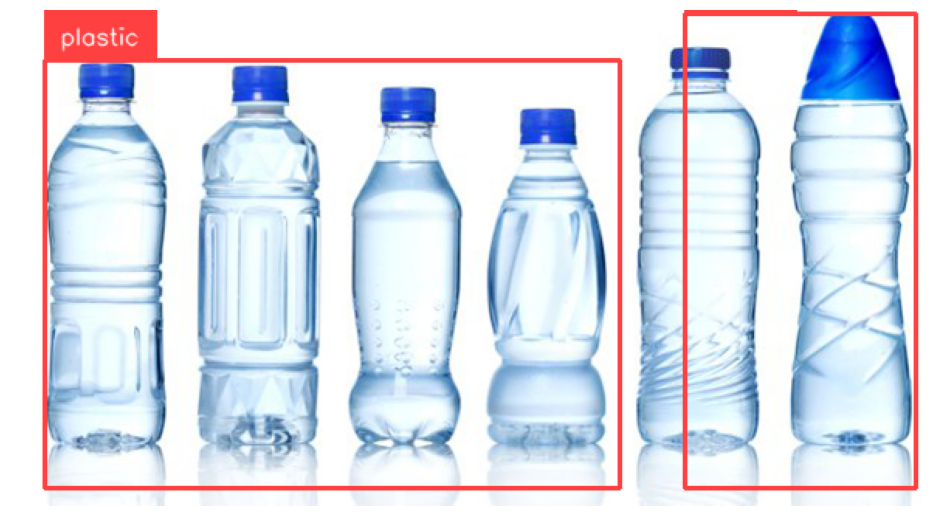

In [29]:
import cv2
import supervision as sv
from ultralytics import YOLO
import requests

# Fetch image from URL and save it to a file
url = 'https://pluspng.com/img-png/3-600.png'
response = requests.get(url)

with open('image.png', 'wb') as f:
    f.write(response.content)

# Read the saved image file
image = cv2.imread('image.png')

results = final_model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_notations = sv.BoxAnnotator()
label_annotations = sv.LabelAnnotator()

annotated_image = bounding_box_notations.annotate(
    scene=image, detections=detections)
annotated_frame = label_annotations.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_frame)

In [28]:
results = final_model.predict(source ='https://richfieldsplastics.com/wp-content/uploads/2020/02/Benefits-of-Replacing-Metal-Parts-with-Plastic.jpg', save=True)
for result in results:
    print(result.boxes.data)

100%|██████████| 422k/422k [00:01<00:00, 307kB/s]

image 1/1 /content/Benefits-of-Replacing-Metal-Parts-with-Plastic.jpg: 384x640 2 metals, 1 plastic, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
tensor([[1.1054e+02, 2.9419e+02, 4.7123e+02, 6.1958e+02, 9.5801e-01, 0.0000e+00],
        [3.5894e+02, 0.0000e+00, 8.3569e+02, 3.5420e+02, 4.6520e-01, 1.0000e+00],
        [3.6173e+02, 0.0000e+00, 7.8153e+02, 3.5174e+02, 2.5836e-01, 0.0000e+00]], device='cuda:0')



0: 384x640 2 metals, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


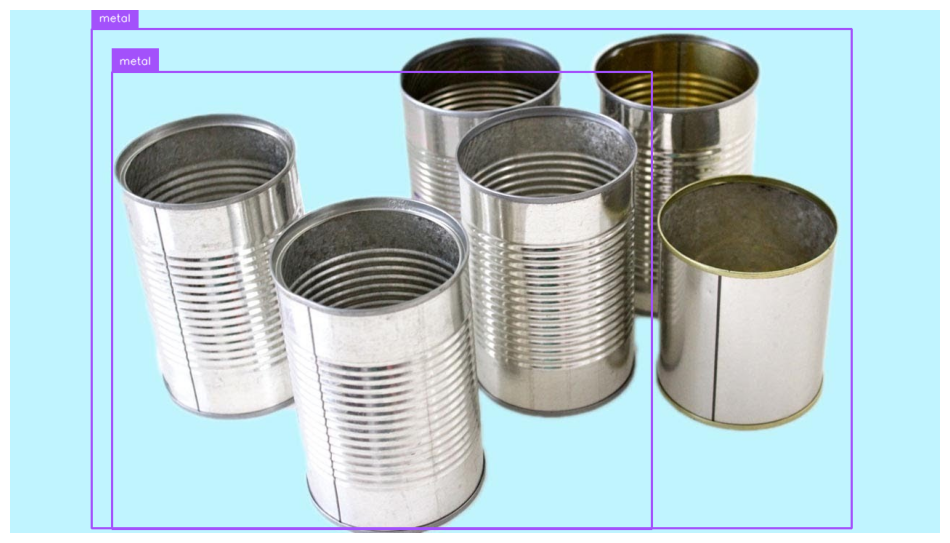

In [32]:
import cv2
import supervision as sv
from ultralytics import YOLO
import requests

# Fetch image from URL and save it to a file
url = 'https://i.ytimg.com/vi/nnOeZTqqp60/maxresdefault.jpg'
response = requests.get(url)

with open('image.png', 'wb') as f:
    f.write(response.content)

# Read the saved image file
image = cv2.imread('image.png')

results = final_model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_notations = sv.BoxAnnotator()
label_annotations = sv.LabelAnnotator()

annotated_image = bounding_box_notations.annotate(
    scene=image, detections=detections)
annotated_frame = label_annotations.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_frame)

## Saving the model

In [38]:
torch.save(YOLO('/content/runs/detect/train433333/weights/best.pt'), 'Imgdetec.pt')

In [43]:
# Loading model to see if it saved well
loaded_model = torch.load('/content/Imgdetec.pt')
metrics = loaded_model.val()
print(f"Validation mAP: {metrics.box.map}")

Ultralytics YOLOv8.2.71 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/AI_Project_Waste_Detect/Trash finder/valid/labels.cache... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        192        196      0.928      0.967       0.98      0.928
                 metal         83         83      0.976       0.97      0.989      0.955
               plastic        109        113       0.88      0.965       0.97      0.901
Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/val5
Validation mAP: 0.9280115175379601
